In [2]:
#Imports
!pip install torcheval
!apt install -y ffmpeg
#!pip install ffmpeg-python

import pandas as pd
import numpy as np
import sys
import gc
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing

from torch.autograd import Variable 
from tqdm import tqdm
import glob
import random
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import torcheval
import timm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torcheval.metrics import BinaryAccuracy


from torch import nn
from sklearn.metrics import matthews_corrcoef
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import math

from timm.scheduler import CosineLRScheduler




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


## **NFL contact detection 2023**

My inference notebook for scoring model: https://www.kaggle.com/code/gumm4n/nfl-inference

*Notebook based on public 2,5D CNN inference notebook made by* **zzy**. *Notebook: https://www.kaggle.com/code/zzy990106/nfl-2-5d-cnn-baseline-inference*


#### Results: 
* My score: 0.52(Matthews correlation cofficient, from -1 to 1, where 1 is perfect 0 is no correct and 0 is random guess)
* Winning score was 0.79

#### *Task:* 
The goal of this competition is to detect external contact experienced by players during an NFL football game. You will use video and player tracking data to identify moments with contact to help improve player safety.
Submissions are evaluated on Matthews Correlation Coefficient between the predicted and actual contact events.

<img align=left src = "attachment:image's http://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F644036%2F65cd663d2c823043b36ecda6c93c1304%2Fcontact-example.gif?generation=1670265252697886&alt=media" width="500">



![](http://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F644036%2F65cd663d2c823043b36ecda6c93c1304%2Fcontact-example.gif?generation=1670265252697886&alt=media)

#### **Data:**
**Videos**
Each play has four associated videos. Two videos, showing a sideline and endzone view, are time synced and aligned with each other. Additionally, an All29 view is provided but not guaranteed to be time synced. The training set videos are in train/ with corresponding labels in train_labels.csv, while the videos for which you must predict are in the test/ folder.

**Tracking data**
Tracking data is provided with player tracking data for every 6th frame. The data contains postitional data as well as for example velocity, accleration and orientation.

**Helmet data**
An imperfect dataset of helmet object detections for all videos exists. Helmet position for each player each frame exists. Data is based on previous Kaggle helmet detection competitions.


#### **Model:**
Main idea was to try old school video classification with (2D CNN + lstm) concatenated with the feature data to be able to understand the temporal video data.

**Input**
* Tracking features, original data for both players + added distance between players -> MLP
* Images for each frame, both sideline and endzone view. -> CNN -> LSTM

**Output**
Given 2 player id's(or 1 player and G(ground)) the model should be able to tell if there is contact or not, 1 or 0.
A threshold of 2m was chosen as a maximum distance possibility for possible contact. Thus all inputs where distance between players > 2 was set as 0.

**2D CNN input**

Two channels were used: One channel with the image centered around the two bounding boxes of the players, and the other channel with only the bounding boxes as well as some features to help the CNN to find where the area of interest are.

*Image channel:*
Due to the players being different size for different videos/frames, one could make use of the size of the helmet bounding box to estimate a area of interest.
* Images were cropped to: max(average bbox width, average bbox height) * 4 (centered in the mean coordinate of the two bboxes).
* Then images were resized to 256x256.

     ![](https://i.ibb.co/Kwv2P7C/nfl-channel1.png)    


*Feature channel:*
* Draw the bounding boxes on blank 256x256 to help the CNN where to look in the image.
* Naively thinking the distance between the players should be the most important feature to classify contact. Thus the color of the bboxes could be changed depending on the distance between the players.
    * Player v ground: *color = 100*
    * Player1 v player2: *color = 255-50*distance* (Ranging from 155(distance = 2) to 255(distance = 0))
    
   ![](https://i.ibb.co/YtD1xLb/nfl-channel2.png)    

**LSTM**
The ouput the from the CNNs, from the sideline and endzone frames are concatenated together into one feature vector.
A sequence of 5 frames each with a time step of 12 frames were used as input into the LSTM.


Output from LSTM model were concatenated with the tracking data features from(passed through a MLP layer) to get the final output as the probability of the specific frame having concatct between p1 and p2.


**Data**
Regular data augmentation were done.
Given the specific frame a randomized frame +-3 frames apart were used to randomize training.
One frame were only used once during training, thus each 6th frame were used. This helped overfitting and minimized the training data alot.

#### *Test:*
No real parameter testing was done due to no availble offline GPU so testing was limited to Kaggle GPU quota. Model is more a concept and made for learning.

#### *Ideas for improvement*
* Split player to player and player to ground detections into two models. Features only of for 1 player, no distance, no 2 boxes and so on. Instead of separating by pixel values and setting features to negative, split the two problems.
* 3D CNN work instead of LSTM, reached better scores in other competitions.
* Maybe use a separate XGB/LGBM model for the tracking data instead of MLP. Then do ensemble after DL model.



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
folder = "/kaggle/input/nfl-player-contact-detection/"


In [5]:
#Function for translating contact_id in input data to different features
def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2].astype("int")
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    df["game_key"] = df["contact_id"].str.split("_").str[-5].astype("int")
    df["play_id"] = df["contact_id"].str.split("_").str[-4].astype("int")
    return df


In [6]:
#Input data

train_labels = expand_contact_id(pd.read_csv(folder+"/train_labels.csv")[["contact_id","contact"]])
train_tracking = pd.read_csv(folder+"/train_player_tracking.csv")
train_helmets = pd.read_csv(folder+"/train_baseline_helmets.csv")
train_video_metadata = pd.read_csv(folder+"/train_video_metadata.csv")

In [7]:
#Finding indexes with both sideline and endzone frames

label_index = train_labels[['game_key', 'play_id',  'nfl_player_id_1', 'step']]
label_index['frame'] = (label_index['step']/10*59.94+5*59.94).astype('int')+1
label_index = label_index[['game_key', 'play_id',  'nfl_player_id_1', 'frame']].reset_index(drop = False)

train_helmet = train_helmets[['game_key', 'play_id',  'nfl_player_id', 'frame', 'view']]
view_list = (train_helmet.groupby(['game_key', 'play_id',  'nfl_player_id', 'frame']).sum())
all_views = view_list[view_list['view'] == 'EndzoneSideline'].reset_index()

df_index = label_index.merge(all_views, how = 'inner', right_on = ['game_key', 'play_id',  'nfl_player_id', 'frame'], left_on = ['game_key', 'play_id',  'nfl_player_id_1', 'frame'])
index_list = df_index['index'].to_list()
sorted_labels = train_labels.iloc[index_list]

/tmp/ipykernel_28/450451848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_index['frame'] = (label_index['step']/10*59.94+5*59.94).astype('int')+1


In [12]:
# Concatenate data for two players and the labels into one feature set. Adding distance feature as well as flagging if its pvp or pvg (p= player, g = ground)


def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols

use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]


train, feature_cols = create_features(sorted_labels, train_tracking, use_cols=use_cols)
train_filtered = train.query('not distance > 2').reset_index(drop=True)
train_filtered['frame'] = (train_filtered['step']/10*59.94+5*59.94).astype('int')+1


In [14]:
del train, train_labels, train_tracking
gc.collect()

23

In [15]:
#Scale features

scaled_features = train_filtered.copy()
features = scaled_features[feature_cols]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features[feature_cols] = features
train_filtered = scaled_features

del scaled_features
gc.collect()

0

In [16]:

train_filtered.sort_values(by=['game_play', 'nfl_player_id_1', 'nfl_player_id_2', 'frame']).reset_index(drop = True)
train_filtered = train_filtered.iloc[5::6,:].reset_index(drop = True)




In [18]:
#Augmentations


train_aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    #A.RandomBrightnessContrast(brightness_limit=(-0.05, 0.05), contrast_limit=(-0.05, 0.05), p=0.3),
    #A.RandomGamma(p=0.5),
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()])

valid_aug = A.Compose([
    A.Normalize(mean=[0.], std=[1.]),
    ToTensorV2()
])

In [19]:
video2helmets = {}
train_helmets_new = train_helmets.set_index('video')
for video in tqdm(train_helmets.video.unique()):
    video2helmets[video] = train_helmets_new.loc[video].reset_index(drop=True)
    
del train_helmets, train_helmets_new
gc.collect()


100%|██████████| 481/481 [01:16<00:00,  6.27it/s]


0

In [20]:
video2frames = {}

for game_play in tqdm(train_video_metadata.game_play.unique()):
    for view in ['Endzone', 'Sideline']:
        video = game_play + f'_{view}.mp4'
        video2frames[video] = max(list(map(lambda x:int(x.split('_')[-1].split('.')[0]), \
                                           glob.glob(f"/kaggle/input/nfl-contact-extracted-train-frames/content/work/frames/train/{video}*"))))

100%|██████████| 240/240 [05:34<00:00,  1.39s/it]


In [21]:
# Data loader, returns wanted feature, label and cropped images([20, 256, 256], 10 frames for each view)


class MyDataset_LSTM(Dataset):
    def __init__(self, df, aug=train_aug):
        self.df = df
        self.frame = df.frame.values
        self.feature = df[feature_cols].fillna(-1).values
        self.players = df[['nfl_player_id_1','nfl_player_id_2']].values
        self.game_play = df.game_play.values
        self.aug = aug
        self.contact_id = df.contact_id.values
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):  
        time_size = 12
        sequence = 5    #number of frames in lstm sequence
        frame = self.frame[idx]
        frame_idx = frame
        
        
        if self.aug == train_aug:
            frame = frame + random.randint(-6, 6)
        frame_diff = frame - frame_idx
        players = []
        
      
        for p in self.players[idx]:
            if p == 'G':
                players.append(p)
            else:
                players.append(int(p))
   
       
        imgs_arr = []
        
        for f in range(frame-((sequence//2)*time_size), frame+((sequence//2)*time_size)+1, time_size):
            imgs = []

            for view in ['Endzone', 'Sideline']:

                video = self.game_play[idx] + f'_{view}.mp4'
                
                tmp = video2helmets[video]           
                tmp = tmp[tmp.nfl_player_id.isin(players)]#.sort_values(['nfl_player_id', 'frame'])         
                tmp = tmp[tmp['frame'] == f]
                
                bboxes = []
                img_size = 0
                if len(tmp['left']):
                  
                    for i in range(len(tmp.index)):
                        
                        x = tmp['left'].tolist()[i]
                        w = tmp['width'].tolist()[i]
                        y = tmp['top'].tolist()[i]
                        h = tmp['height'].tolist()[i]
                        if math.isfinite(x):
                            bboxes.append([x, w, y, h])
                            img_size = max([img_size, w, h])
                            
                        
                        
                    img_helmet = np.zeros((720,1280), dtype=np.float32)  
                    if len(tmp) == 2:
                        
                        
                        #df_dist = self.df[(self.df['game_play'] == self.game_play) &
                        #                   (self.df['nfl_player_id_1'] == str(players[0]))  & (self.df['nfl_player_id_2'] == str(players[1]))]
                        #closest_frame = min(df_dist.frame.values, key=lambda x:abs(x-(f-frame_diff)))
                        dist = self.df.distance[idx]

                        if math.isfinite(dist):
                            color_dist = int(156+(100-(100*dist)))
                            
                        else:
                            color_dist = 100
                           
                        color = (color_dist, 0, 0)                        
                        
                    else:
                        color = (100, 0, 0)
                    
                    
                    for i in range(len(tmp)):
                        
                        start_point = (bboxes[i][0], bboxes[i][2])
                        end_point = (bboxes[i][0] +  bboxes[i][1], bboxes[i][2] + bboxes[i][3])
                        

                        img_helmet = cv2.rectangle(img_helmet, start_point, end_point, color, thickness =-1)
                    
                    
                    img_new = np.zeros((256, 256), dtype=np.float32)         
                    img = cv2.imread(f"/kaggle/input/nfl-contact-extracted-train-frames/content/work/frames/train/{video}_{f:04d}.jpg", 0)

                    
                    if len(tmp) == 2:  
                        x = ((bboxes[0][0] + bboxes[1][0])/2) + ((bboxes[0][1] + bboxes[1][1])/4)
                        y = ((bboxes[0][2] + bboxes[1][2])/2) + ((bboxes[0][3] + bboxes[1][3])/4)   
                    else: 
                        x = bboxes[0][0] + (bboxes[0][1]/2)
                        y = bboxes[0][2] + (bboxes[0][3]/2)
                   
                    if x < img_size*4:
                            x = img_size * 4
                    if y < img_size * 4:
                            y = img_size * 4
                 
                    if img.size == 0:      
                        img_h = np.zeros((256,256), dtype=np.float32) 
                        img_new = np.zeros((256, 256), dtype=np.float32) 
                        
                    else:
                        
                        
                        img = img[int(y)-img_size*4:int(y)+img_size*4,int(x)-img_size*4:int(x)+img_size*4].copy()
                       
                        
                        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_LINEAR)
                        
                        img_new[:img.shape[0], :img.shape[1]] = img 
                        
                        #img = img[int(y)-128:int(y)+128,int(x)-128:int(x)+128].copy()
                        img_helmet = img_helmet[int(y)-img_size*4:int(y)+img_size*4,int(x)-img_size*4:int(x)+img_size*4].copy()
                        img_helmet = cv2.resize(img_helmet, dsize=(256, 256), interpolation=cv2.INTER_CUBIC)

                      
                        



                        img_h = np.zeros((256, 256), dtype=np.float32)         
                        img_h[:img_helmet.shape[0], :img_helmet.shape[1]] = img_helmet               
                             
                else:
                    
                    img_h = np.zeros((256,256), dtype=np.float32) 
                    img_new = np.zeros((256, 256), dtype=np.float32)   


                imgs.append(img_new)
                imgs.append(img_h)
                
            imgs_arr.append(imgs)
       
                
        feature = np.float32(self.feature[idx])
         
   
 
        imga = np.array(imgs_arr)

        b, c, h, w = imga.shape
        imga = imga.reshape(b//b, c*sequence, h, w)
        imga = np.squeeze(imga)
        imga = imga.transpose(1,2,0)
    
        imga = self.aug(image=imga)["image"]
        label = np.float32(self.df.contact.values[idx])

        
        return imga, feature, label
    


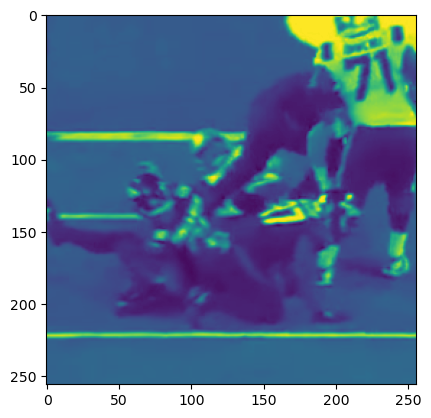

(torch.Size([20, 256, 256]),
 array([0.8472806 , 0.46470588, 0.00473934, 0.        , 0.83543986,
        0.37403816, 0.08717949, 0.4392073 , 0.8508058 , 0.48751217,
        0.04970179, 0.04901961, 0.17009278, 0.1657592 , 0.03897436,
        0.49462366, 0.5038045 , 0.        ], dtype=float32),
 0.0)

In [22]:
img, feature, label = MyDataset_LSTM(train_filtered, valid_aug)[15900]
plt.imshow(img.permute(1,2,0)[:,:,0])
plt.rcParams["figure.figsize"] = 3,3

plt.show()
img.shape, feature, label





In [25]:
print(len(train_filtered['G_flug']))
print(sum(train_filtered['contact']))
print(sum(train_filtered['G_flug']))


3987


In [32]:
class Model(nn.Module):
    def __init__(self, num_layers = 1, input_size = 256, hidden_size = 64, seq_length = 5):
        super(Model, self).__init__()
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length
        
        #efficientnet_b1
        self.backbone = timm.create_model('resnet50', pretrained=True, num_classes=128, in_chans=2)
        
                
        self.mlp = nn.Sequential(
            nn.Linear(18, 32),
            nn.LayerNorm(32),
            nn.ReLU(),
            nn.Dropout(0.2),
         
        )

        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) 
        self.fc_lstm = nn.Linear(hidden_size, 128) 
        
        self.softmax = nn.Softmax()
        self.fc = nn.Linear(128+32, 1)

    def forward(self, img, x):
        
        b, c, h, w = img.shape   
        img = img.reshape(b*(c//2),c//(c//2), h, w)
        img = self.backbone(img)
        img = img.reshape(b,self.seq_length, -1)


        h_0 = Variable(torch.zeros(self.num_layers, img.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, img.size(0), self.hidden_size)).to(device) #internal state



        output, (hn, cn) = self.lstm(img, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.softmax(hn)
        out = self.fc_lstm(out)
        #out = self.softmax(out)
    
        feature = self.mlp(x)

        #feature = torch.transpose(feature, 0, 1)
        y = self.fc(torch.cat([out, feature], dim=1))
        return y

In [33]:
train_data,val_data = train_test_split(train_filtered,test_size=0.1, random_state=42,stratify = train_filtered['contact'])
train_data = train_data.reset_index(drop = True)
val_data = val_data.reset_index(drop = True)
batch_size = 16

train_set = MyDataset_LSTM(train_data, train_aug)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_set = MyDataset_LSTM(val_data, valid_aug)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

model = Model()

model= nn.DataParallel(model)
model.to(device)
#model.backbone.requires_grad_(False)

metric = BinaryAccuracy(threshold = 0.0)
val_metric = BinaryAccuracy(threshold = 0.0)


criterion = nn.BCEWithLogitsLoss()


In [35]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay= 1e-6,)
nbatch = len(train_loader)
warmup = 1* nbatch
nsteps = 6 * nbatch 


scheduler = CosineLRScheduler(optimizer,warmup_t=warmup, warmup_lr_init=0.0, warmup_prefix=True,t_initial=(nsteps - warmup), lr_min=1e-6)                


In [36]:
best_loss = 0
for epoch in range(6):  # loop over the dataset multiple times
    i = 0
    
    
    #train_set = MyDataset_LSTM(train_data[epoch%9], train_aug)
    #train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    
    
    
    
    model.train()
    for batch,(img, feature, label) in tqdm(enumerate(train_loader),total = len(train_loader)):
        
        loss_sum = 0.0
        n_sum = 0
        img = img.to(device)
        feature = feature.to(device)
        label = label.to(device)
        n = label.size(0)

        
        output = model(img, feature).reshape(-1)
   
        optimizer.zero_grad()
        metric = BinaryAccuracy(threshold = 0.0)

        metric.update(output.cpu(), label.cpu())
        
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        scheduler.step(epoch * nbatch + batch + 1)


        train_loss = loss.item()
        loss_sum += n * train_loss
        n_sum += n

        nn.utils.clip_grad_norm_(model.parameters(), 1000)

        if batch % 10 == 9:    # print every 2000 mini-batches
            loss_train = loss_sum / n_sum
            print(f'[{epoch + 1}, {batch + 1:5d}] loss: {loss_train:.3f}')
            
        if batch % 100 == 9:  
            print(output)
            print(label)
        del label, img, feature, output
        gc.collect()
    
        n = 0
        score = 0.0
    print('Validating model')
    model.eval()
    test_loss_sum = 0.0
    test_n_sum = 0
    test_n = 0
    for batch,(img, feature, label) in tqdm(enumerate(val_loader),total = len(val_loader)):
        test_n = label.size(0)
        img = img.to(device)
        feature = feature.to(device)
        label = label.to(device)
        
        with torch.no_grad():
            output = model(img, feature).reshape(-1)
            loss = criterion(output, label)
        test_loss = loss.item()
        test_loss_sum += test_n * test_loss
        test_n_sum += test_n
        i += 1
        metric = BinaryAccuracy(threshold = 0.0)
        
        
        

        metric.update(output.cpu(), label.cpu())
        score = score + metric.compute()
        n = n + 1


        del label, img, feature, output
        gc.collect()
    val_loss = test_loss_sum / test_n_sum
    val_score = score/n
    
    if val_loss < best_loss:
        best_loss = val_loss
        # Save model
        ofilename = 'nfl_model.pytorch'
        torch.save(model.state_dict(), ofilename)
        print(ofilename, 'written')
    
    
    print(f'Validation accuracy: {val_score}')
    print(f'Validation loss: {val_loss}')
    
    

  0%|          | 0/2076 [00:00<?, ?it/s]/tmp/ipykernel_28/1383870055.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = self.softmax(hn)
  0%|          | 9/2076 [00:20<1:12:54,  2.12s/it]

[1,    10] loss: 0.761
tensor([ 0.1982, -0.0250,  0.2815,  0.1239,  0.0759,  0.1164,  0.1535,  0.2694,
         0.2299, -0.0135,  0.0724,  0.1175,  0.1453,  0.2475,  0.2564, -0.2142],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  1%|          | 19/2076 [00:41<1:16:16,  2.23s/it]

[1,    20] loss: 0.755


  1%|▏         | 29/2076 [01:01<1:16:42,  2.25s/it]

[1,    30] loss: 0.750


  2%|▏         | 39/2076 [01:21<1:13:04,  2.15s/it]

[1,    40] loss: 0.742


  2%|▏         | 49/2076 [01:42<1:13:49,  2.19s/it]

[1,    50] loss: 0.734


  3%|▎         | 59/2076 [02:02<1:08:53,  2.05s/it]

[1,    60] loss: 0.711


  3%|▎         | 69/2076 [02:22<1:07:48,  2.03s/it]

[1,    70] loss: 0.740


  4%|▍         | 79/2076 [02:43<1:11:21,  2.14s/it]

[1,    80] loss: 0.730


  4%|▍         | 90/2076 [03:05<1:05:42,  1.99s/it]

[1,    90] loss: 0.709


  5%|▍         | 99/2076 [03:25<1:12:30,  2.20s/it]

[1,   100] loss: 0.712


  5%|▌         | 109/2076 [03:46<1:11:54,  2.19s/it]

[1,   110] loss: 0.714
tensor([ 0.0854,  0.0308,  0.0618,  0.0358,  0.0763,  0.1072,  0.1482, -0.0276,
         0.1919,  0.0546,  0.1339,  0.0542, -0.2524,  0.1190,  0.0438, -0.0161],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
       device='cuda:0')


  6%|▌         | 119/2076 [04:07<1:10:55,  2.17s/it]

[1,   120] loss: 0.698


  6%|▌         | 129/2076 [04:27<1:08:38,  2.12s/it]

[1,   130] loss: 0.683


  7%|▋         | 140/2076 [04:50<1:05:00,  2.01s/it]

[1,   140] loss: 0.657


  7%|▋         | 149/2076 [05:08<1:08:32,  2.13s/it]

[1,   150] loss: 0.660


  8%|▊         | 159/2076 [05:29<1:04:59,  2.03s/it]

[1,   160] loss: 0.651


  8%|▊         | 169/2076 [05:49<1:13:15,  2.30s/it]

[1,   170] loss: 0.672


  9%|▊         | 179/2076 [06:08<1:06:03,  2.09s/it]

[1,   180] loss: 0.616


  9%|▉         | 189/2076 [06:29<1:08:52,  2.19s/it]

[1,   190] loss: 0.609


 10%|▉         | 200/2076 [06:51<1:00:45,  1.94s/it]

[1,   200] loss: 0.614


 10%|█         | 209/2076 [07:10<1:05:21,  2.10s/it]

[1,   210] loss: 0.609
tensor([-0.1616, -0.2325, -0.2228, -0.2901, -0.2524, -0.4735, -0.2571, -0.1802,
        -0.2866, -0.2122, -0.3410, -0.2179, -0.4869, -0.2681, -0.2900, -0.2480],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 11%|█         | 219/2076 [07:30<1:04:37,  2.09s/it]

[1,   220] loss: 0.595


 11%|█         | 229/2076 [07:50<1:04:36,  2.10s/it]

[1,   230] loss: 0.566


 12%|█▏        | 239/2076 [08:11<1:06:50,  2.18s/it]

[1,   240] loss: 0.520


 12%|█▏        | 249/2076 [08:32<1:08:09,  2.24s/it]

[1,   250] loss: 0.600


 12%|█▏        | 259/2076 [08:52<1:03:32,  2.10s/it]

[1,   260] loss: 0.525


 13%|█▎        | 269/2076 [09:12<1:01:08,  2.03s/it]

[1,   270] loss: 0.505


 13%|█▎        | 279/2076 [09:33<1:08:58,  2.30s/it]

[1,   280] loss: 0.552


 14%|█▍        | 289/2076 [09:53<1:02:28,  2.10s/it]

[1,   290] loss: 0.424


 14%|█▍        | 299/2076 [10:13<1:04:01,  2.16s/it]

[1,   300] loss: 0.434


 15%|█▍        | 309/2076 [10:33<1:01:21,  2.08s/it]

[1,   310] loss: 0.477
tensor([-0.8072, -0.7307, -0.7994, -0.7978, -0.7790, -0.7535, -0.8416, -0.7796,
        -0.6987, -0.7511, -0.7136, -0.7489, -0.8134, -0.7547, -0.7424, -0.8393],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 15%|█▌        | 319/2076 [10:54<1:03:01,  2.15s/it]

[1,   320] loss: 0.415


 16%|█▌        | 329/2076 [11:15<59:12,  2.03s/it]  

[1,   330] loss: 0.508


 16%|█▋        | 339/2076 [11:35<1:00:10,  2.08s/it]

[1,   340] loss: 0.552


 17%|█▋        | 349/2076 [11:55<1:01:06,  2.12s/it]

[1,   350] loss: 0.440


 17%|█▋        | 359/2076 [12:15<1:00:49,  2.13s/it]

[1,   360] loss: 0.481


 18%|█▊        | 369/2076 [12:35<58:20,  2.05s/it]  

[1,   370] loss: 0.473


 18%|█▊        | 379/2076 [12:56<59:07,  2.09s/it]  

[1,   380] loss: 0.541


 19%|█▊        | 389/2076 [13:16<59:34,  2.12s/it]  

[1,   390] loss: 0.326


 19%|█▉        | 399/2076 [13:35<57:54,  2.07s/it]

[1,   400] loss: 0.249


 20%|█▉        | 409/2076 [13:56<58:08,  2.09s/it]  

[1,   410] loss: 0.461
tensor([-1.0786, -1.5159, -1.3276, -1.1657, -1.4100, -1.2347, -1.5194, -1.5283,
        -1.2724, -1.3348, -1.2712, -1.5871, -1.2170, -1.2006, -1.1577, -1.5092],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       device='cuda:0')


 20%|██        | 419/2076 [14:15<55:34,  2.01s/it]

[1,   420] loss: 0.531


 21%|██        | 429/2076 [14:35<56:33,  2.06s/it]

[1,   430] loss: 0.552


 21%|██        | 439/2076 [14:55<58:45,  2.15s/it]

[1,   440] loss: 0.388


 22%|██▏       | 449/2076 [15:15<57:29,  2.12s/it]

[1,   450] loss: 0.312


 22%|██▏       | 459/2076 [15:36<55:53,  2.07s/it]  

[1,   460] loss: 0.257


 23%|██▎       | 469/2076 [15:57<1:01:37,  2.30s/it]

[1,   470] loss: 0.334


 23%|██▎       | 479/2076 [16:16<55:11,  2.07s/it]  

[1,   480] loss: 0.338


 24%|██▎       | 489/2076 [16:37<57:37,  2.18s/it]

[1,   490] loss: 0.174


 24%|██▍       | 499/2076 [16:58<59:47,  2.27s/it]

[1,   500] loss: 0.251


 25%|██▍       | 509/2076 [17:18<54:00,  2.07s/it]

[1,   510] loss: 0.411
tensor([-2.2343, -2.0847, -2.0174, -1.4339, -1.4305, -2.2752, -1.5138, -1.4244,
        -2.0526, -1.5161, -2.0144, -2.1214, -2.1783, -2.1800, -2.1734, -1.1341],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
       device='cuda:0')


 25%|██▌       | 519/2076 [17:38<52:44,  2.03s/it]

[1,   520] loss: 0.427


 25%|██▌       | 529/2076 [17:58<54:13,  2.10s/it]

[1,   530] loss: 0.137


 26%|██▌       | 539/2076 [18:19<55:17,  2.16s/it]

[1,   540] loss: 0.140


 26%|██▋       | 549/2076 [18:39<55:31,  2.18s/it]

[1,   550] loss: 0.225


 27%|██▋       | 559/2076 [18:59<52:05,  2.06s/it]

[1,   560] loss: 0.343


 27%|██▋       | 569/2076 [19:19<51:28,  2.05s/it]

[1,   570] loss: 0.535


 28%|██▊       | 579/2076 [19:38<49:00,  1.96s/it]

[1,   580] loss: 0.306


 28%|██▊       | 589/2076 [19:58<52:28,  2.12s/it]

[1,   590] loss: 0.470


 29%|██▉       | 599/2076 [20:18<51:18,  2.08s/it]

[1,   600] loss: 0.218


 29%|██▉       | 609/2076 [20:38<48:09,  1.97s/it]

[1,   610] loss: 0.290
tensor([-2.5680, -2.3620, -2.6070, -1.2227, -2.4666, -1.7464, -1.6591, -1.2323,
        -1.7988, -2.5425, -1.5486, -1.1660, -2.3825, -1.8668, -2.5474, -2.5137],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 30%|██▉       | 619/2076 [20:58<51:14,  2.11s/it]

[1,   620] loss: 0.112


 30%|███       | 629/2076 [21:18<51:09,  2.12s/it]

[1,   630] loss: 0.360


 31%|███       | 639/2076 [21:38<48:28,  2.02s/it]

[1,   640] loss: 0.381


 31%|███▏      | 649/2076 [21:59<48:03,  2.02s/it]

[1,   650] loss: 0.139


 32%|███▏      | 659/2076 [22:19<48:37,  2.06s/it]

[1,   660] loss: 0.192


 32%|███▏      | 669/2076 [22:41<52:07,  2.22s/it]

[1,   670] loss: 0.166


 33%|███▎      | 679/2076 [23:02<50:27,  2.17s/it]

[1,   680] loss: 0.370


 33%|███▎      | 689/2076 [23:24<54:13,  2.35s/it]

[1,   690] loss: 0.115


 34%|███▎      | 699/2076 [23:44<45:49,  2.00s/it]

[1,   700] loss: 0.178


 34%|███▍      | 709/2076 [24:04<44:58,  1.97s/it]

[1,   710] loss: 0.489
tensor([-3.2365, -1.8079, -2.8669, -3.1298, -3.2571, -1.1050, -3.3204, -2.5556,
        -2.0372, -2.9202, -3.1612, -2.8031, -3.0487, -3.1471, -1.1154, -2.4390],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 35%|███▍      | 719/2076 [24:25<47:07,  2.08s/it]

[1,   720] loss: 0.410


 35%|███▌      | 729/2076 [24:46<46:19,  2.06s/it]

[1,   730] loss: 0.318


 36%|███▌      | 739/2076 [25:07<46:37,  2.09s/it]

[1,   740] loss: 0.165


 36%|███▌      | 749/2076 [25:27<46:14,  2.09s/it]

[1,   750] loss: 0.176


 37%|███▋      | 759/2076 [25:47<43:37,  1.99s/it]

[1,   760] loss: 0.519


 37%|███▋      | 769/2076 [26:08<44:30,  2.04s/it]

[1,   770] loss: 0.629


 38%|███▊      | 779/2076 [26:27<40:02,  1.85s/it]

[1,   780] loss: 0.188


 38%|███▊      | 789/2076 [26:47<40:36,  1.89s/it]

[1,   790] loss: 0.138


 38%|███▊      | 799/2076 [27:07<39:41,  1.87s/it]

[1,   800] loss: 0.306


 39%|███▉      | 809/2076 [27:27<40:10,  1.90s/it]

[1,   810] loss: 0.558
tensor([-2.8971, -0.7450, -2.0672, -2.8001, -3.0990, -2.0523, -1.2844, -2.1560,
        -3.0171, -1.6954, -1.7903, -2.6428, -1.7208, -1.3777, -1.6038, -2.8295],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 39%|███▉      | 819/2076 [27:48<41:02,  1.96s/it]

[1,   820] loss: 0.180


 40%|███▉      | 829/2076 [28:08<39:01,  1.88s/it]

[1,   830] loss: 0.414


 40%|████      | 839/2076 [28:28<38:58,  1.89s/it]

[1,   840] loss: 0.158


 41%|████      | 849/2076 [28:49<42:06,  2.06s/it]

[1,   850] loss: 0.105


 41%|████▏     | 859/2076 [29:08<37:59,  1.87s/it]

[1,   860] loss: 0.334


 42%|████▏     | 870/2076 [29:31<41:38,  2.07s/it]

[1,   870] loss: 0.425


 42%|████▏     | 879/2076 [29:48<41:28,  2.08s/it]

[1,   880] loss: 0.294


 43%|████▎     | 889/2076 [30:08<36:59,  1.87s/it]

[1,   890] loss: 0.285


 43%|████▎     | 899/2076 [30:28<37:28,  1.91s/it]

[1,   900] loss: 0.302


 44%|████▍     | 909/2076 [30:47<36:04,  1.85s/it]

[1,   910] loss: 0.131
tensor([-3.4653, -3.5600, -0.6826, -3.4367, -3.3740, -3.4651, -0.5361, -2.2601,
        -3.4184, -3.3215, -2.4265, -1.7578, -3.3390, -2.7597, -0.3726, -3.3838],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 44%|████▍     | 919/2076 [31:08<35:47,  1.86s/it]

[1,   920] loss: 0.248


 45%|████▍     | 929/2076 [31:28<38:09,  2.00s/it]

[1,   930] loss: 0.181


 45%|████▌     | 939/2076 [31:47<35:54,  1.90s/it]

[1,   940] loss: 0.125


 46%|████▌     | 949/2076 [32:07<35:12,  1.87s/it]

[1,   950] loss: 0.274


 46%|████▌     | 959/2076 [32:27<34:02,  1.83s/it]

[1,   960] loss: 0.422


 47%|████▋     | 969/2076 [32:47<34:23,  1.86s/it]

[1,   970] loss: 0.233


 47%|████▋     | 979/2076 [33:08<36:39,  2.00s/it]

[1,   980] loss: 0.122


 48%|████▊     | 989/2076 [33:27<34:52,  1.93s/it]

[1,   990] loss: 0.367


 48%|████▊     | 999/2076 [33:48<34:37,  1.93s/it]

[1,  1000] loss: 0.081


 49%|████▊     | 1009/2076 [34:08<34:41,  1.95s/it]

[1,  1010] loss: 0.153
tensor([-3.6574, -3.3805, -0.7726, -3.7767, -2.5056, -3.4425, -4.0842, -0.5881,
        -0.5698, -2.0032, -2.2780, -3.0158, -2.9808, -3.8724, -3.5309, -3.5970],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 49%|████▉     | 1019/2076 [34:28<33:33,  1.90s/it]

[1,  1020] loss: 0.136


 50%|████▉     | 1029/2076 [34:48<32:30,  1.86s/it]

[1,  1030] loss: 0.132


 50%|█████     | 1039/2076 [35:09<35:26,  2.05s/it]

[1,  1040] loss: 0.550


 51%|█████     | 1049/2076 [35:28<31:32,  1.84s/it]

[1,  1050] loss: 0.191


 51%|█████     | 1059/2076 [35:48<33:28,  1.98s/it]

[1,  1060] loss: 0.377


 51%|█████▏    | 1069/2076 [36:08<31:51,  1.90s/it]

[1,  1070] loss: 0.289


 52%|█████▏    | 1079/2076 [36:28<31:11,  1.88s/it]

[1,  1080] loss: 0.290


 52%|█████▏    | 1089/2076 [36:48<32:38,  1.98s/it]

[1,  1090] loss: 0.146


 53%|█████▎    | 1099/2076 [37:08<30:07,  1.85s/it]

[1,  1100] loss: 0.515


 53%|█████▎    | 1109/2076 [37:28<31:27,  1.95s/it]

[1,  1110] loss: 0.105
tensor([-3.5507, -2.0129, -2.8673, -3.5230, -3.4970, -3.6073, -3.8377, -3.4523,
        -1.7222, -2.7884, -3.2961, -0.3653, -1.9788, -4.0774, -4.1598, -3.7318],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 54%|█████▍    | 1119/2076 [37:49<32:23,  2.03s/it]

[1,  1120] loss: 0.141


 54%|█████▍    | 1129/2076 [38:08<29:54,  1.89s/it]

[1,  1130] loss: 0.151


 55%|█████▍    | 1139/2076 [38:28<30:11,  1.93s/it]

[1,  1140] loss: 0.449


 55%|█████▌    | 1149/2076 [38:49<30:28,  1.97s/it]

[1,  1150] loss: 0.393


 56%|█████▌    | 1159/2076 [39:10<30:08,  1.97s/it]

[1,  1160] loss: 0.231


 56%|█████▋    | 1169/2076 [39:31<30:33,  2.02s/it]

[1,  1170] loss: 0.308


 57%|█████▋    | 1179/2076 [39:51<28:38,  1.92s/it]

[1,  1180] loss: 0.138


 57%|█████▋    | 1189/2076 [40:11<28:52,  1.95s/it]

[1,  1190] loss: 0.467


 58%|█████▊    | 1199/2076 [40:31<30:07,  2.06s/it]

[1,  1200] loss: 0.228


 58%|█████▊    | 1209/2076 [40:51<30:06,  2.08s/it]

[1,  1210] loss: 0.413
tensor([-2.9497, -4.5568, -3.1619, -3.1498, -2.5467, -3.9029, -0.2904, -4.1558,
        -1.1128, -3.2769, -4.1080, -2.2788, -3.9831, -1.4853, -4.3165, -4.2276],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 59%|█████▊    | 1219/2076 [41:11<29:37,  2.07s/it]

[1,  1220] loss: 0.067


 59%|█████▉    | 1229/2076 [41:31<29:18,  2.08s/it]

[1,  1230] loss: 0.091


 60%|█████▉    | 1239/2076 [41:52<29:46,  2.13s/it]

[1,  1240] loss: 0.267


 60%|██████    | 1249/2076 [42:13<29:28,  2.14s/it]

[1,  1250] loss: 0.189


 61%|██████    | 1259/2076 [42:33<27:48,  2.04s/it]

[1,  1260] loss: 0.306


 61%|██████    | 1269/2076 [42:54<29:18,  2.18s/it]

[1,  1270] loss: 0.048


 62%|██████▏   | 1279/2076 [43:16<27:53,  2.10s/it]

[1,  1280] loss: 0.065


 62%|██████▏   | 1289/2076 [43:36<26:38,  2.03s/it]

[1,  1290] loss: 0.148


 63%|██████▎   | 1299/2076 [43:58<26:47,  2.07s/it]

[1,  1300] loss: 0.120


 63%|██████▎   | 1309/2076 [44:19<27:58,  2.19s/it]

[1,  1310] loss: 0.131
tensor([-1.2128, -2.2370, -4.3635, -4.1585, -3.8754, -4.4833, -1.2383, -4.2954,
        -4.1026, -0.4661, -3.8056, -4.3222, -4.3262,  0.1944, -4.5585, -2.8826],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 64%|██████▎   | 1319/2076 [44:39<27:46,  2.20s/it]

[1,  1320] loss: 0.334


 64%|██████▍   | 1329/2076 [45:01<27:19,  2.19s/it]

[1,  1330] loss: 0.566


 64%|██████▍   | 1339/2076 [45:22<28:20,  2.31s/it]

[1,  1340] loss: 0.361


 65%|██████▍   | 1349/2076 [45:43<27:16,  2.25s/it]

[1,  1350] loss: 0.299


 65%|██████▌   | 1359/2076 [46:04<25:06,  2.10s/it]

[1,  1360] loss: 0.146


 66%|██████▌   | 1369/2076 [46:26<26:39,  2.26s/it]

[1,  1370] loss: 0.070


 66%|██████▋   | 1379/2076 [46:45<24:16,  2.09s/it]

[1,  1380] loss: 0.062


 67%|██████▋   | 1389/2076 [47:06<23:33,  2.06s/it]

[1,  1390] loss: 0.092


 67%|██████▋   | 1399/2076 [47:27<26:46,  2.37s/it]

[1,  1400] loss: 0.051


 68%|██████▊   | 1409/2076 [47:47<22:53,  2.06s/it]

[1,  1410] loss: 0.051
tensor([-3.2537, -2.0635, -2.4437, -3.4224, -4.0190, -2.4834, -3.8919, -4.2072,
        -1.8283, -4.1144, -4.0975, -4.1008, -2.1796, -2.9284, -3.6066, -3.3845],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 68%|██████▊   | 1419/2076 [48:08<24:14,  2.21s/it]

[1,  1420] loss: 0.106


 69%|██████▉   | 1429/2076 [48:28<23:19,  2.16s/it]

[1,  1430] loss: 0.297


 69%|██████▉   | 1439/2076 [48:49<23:08,  2.18s/it]

[1,  1440] loss: 0.047


 70%|██████▉   | 1449/2076 [49:09<22:47,  2.18s/it]

[1,  1450] loss: 0.315


 70%|███████   | 1459/2076 [49:30<22:02,  2.14s/it]

[1,  1460] loss: 0.142


 71%|███████   | 1469/2076 [49:50<20:46,  2.05s/it]

[1,  1470] loss: 0.095


 71%|███████   | 1479/2076 [50:10<20:59,  2.11s/it]

[1,  1480] loss: 0.227


 72%|███████▏  | 1489/2076 [50:30<19:53,  2.03s/it]

[1,  1490] loss: 0.439


 72%|███████▏  | 1499/2076 [50:50<19:42,  2.05s/it]

[1,  1500] loss: 0.159


 73%|███████▎  | 1509/2076 [51:09<19:11,  2.03s/it]

[1,  1510] loss: 0.118
tensor([-4.1058, -4.0902, -3.9229, -1.4560, -3.6561, -4.0616, -4.5555,  0.1020,
         1.4917,  0.9127, -3.8893, -4.2494, -4.1818, -1.0117, -4.1480, -4.1459],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 73%|███████▎  | 1519/2076 [51:30<20:36,  2.22s/it]

[1,  1520] loss: 0.422


 74%|███████▎  | 1529/2076 [51:50<18:48,  2.06s/it]

[1,  1530] loss: 0.106


 74%|███████▍  | 1539/2076 [52:10<18:12,  2.03s/it]

[1,  1540] loss: 0.195


 75%|███████▍  | 1549/2076 [52:30<18:22,  2.09s/it]

[1,  1550] loss: 0.335


 75%|███████▌  | 1559/2076 [52:51<19:17,  2.24s/it]

[1,  1560] loss: 0.253


 76%|███████▌  | 1569/2076 [53:10<17:35,  2.08s/it]

[1,  1570] loss: 0.447


 76%|███████▌  | 1579/2076 [53:31<17:45,  2.14s/it]

[1,  1580] loss: 0.236


 77%|███████▋  | 1589/2076 [53:50<16:47,  2.07s/it]

[1,  1590] loss: 0.399


 77%|███████▋  | 1599/2076 [54:10<16:24,  2.06s/it]

[1,  1600] loss: 0.222


 78%|███████▊  | 1609/2076 [54:30<16:23,  2.11s/it]

[1,  1610] loss: 0.666
tensor([-4.3222,  0.9546, -3.7355, -2.2447, -3.8655, -4.0896, -3.2276, -3.5234,
        -3.8121, -3.5637, -3.1227, -3.2389, -3.6366, -3.8205, -3.2329, -1.5051],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 78%|███████▊  | 1619/2076 [54:50<15:41,  2.06s/it]

[1,  1620] loss: 0.450


 78%|███████▊  | 1629/2076 [55:10<15:30,  2.08s/it]

[1,  1630] loss: 0.196


 79%|███████▉  | 1639/2076 [55:30<15:17,  2.10s/it]

[1,  1640] loss: 0.602


 79%|███████▉  | 1649/2076 [55:49<13:33,  1.91s/it]

[1,  1650] loss: 0.241


 80%|███████▉  | 1659/2076 [56:10<14:07,  2.03s/it]

[1,  1660] loss: 0.185


 80%|████████  | 1669/2076 [56:29<13:03,  1.93s/it]

[1,  1670] loss: 0.240


 81%|████████  | 1679/2076 [56:50<13:38,  2.06s/it]

[1,  1680] loss: 0.139


 81%|████████▏ | 1689/2076 [57:10<13:28,  2.09s/it]

[1,  1690] loss: 0.378


 82%|████████▏ | 1699/2076 [57:29<12:23,  1.97s/it]

[1,  1700] loss: 0.242


 82%|████████▏ | 1709/2076 [57:49<12:21,  2.02s/it]

[1,  1710] loss: 0.155
tensor([-2.2988, -3.5834,  0.5139, -3.9470, -3.5455,  0.7344, -4.2430, -3.8473,
        -4.3446, -4.2905, -3.6896, -3.9503,  0.9601, -3.8616, -4.4925, -3.7895],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 83%|████████▎ | 1719/2076 [58:10<12:27,  2.09s/it]

[1,  1720] loss: 0.406


 83%|████████▎ | 1729/2076 [58:30<11:15,  1.95s/it]

[1,  1730] loss: 0.114


 84%|████████▍ | 1739/2076 [58:50<10:59,  1.96s/it]

[1,  1740] loss: 0.472


 84%|████████▍ | 1749/2076 [59:10<10:25,  1.91s/it]

[1,  1750] loss: 0.202


 85%|████████▍ | 1759/2076 [59:30<09:53,  1.87s/it]

[1,  1760] loss: 0.064


 85%|████████▌ | 1769/2076 [59:51<10:18,  2.01s/it]

[1,  1770] loss: 0.138


 86%|████████▌ | 1779/2076 [1:00:10<09:12,  1.86s/it]

[1,  1780] loss: 0.332


 86%|████████▌ | 1789/2076 [1:00:31<09:05,  1.90s/it]

[1,  1790] loss: 0.062


 87%|████████▋ | 1799/2076 [1:00:51<09:14,  2.00s/it]

[1,  1800] loss: 0.621


 87%|████████▋ | 1809/2076 [1:01:11<08:35,  1.93s/it]

[1,  1810] loss: 0.619
tensor([ 0.7936, -4.3047, -0.3903, -0.2269, -4.2464, -2.5112, -3.9779, -4.0111,
        -3.8323, -4.2211, -3.6387, -2.9093, -3.9131, -0.1358, -3.6285, -3.2371],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 88%|████████▊ | 1819/2076 [1:01:31<08:13,  1.92s/it]

[1,  1820] loss: 0.061


 88%|████████▊ | 1829/2076 [1:01:51<07:36,  1.85s/it]

[1,  1830] loss: 0.326


 89%|████████▊ | 1839/2076 [1:02:11<07:29,  1.89s/it]

[1,  1840] loss: 0.191


 89%|████████▉ | 1849/2076 [1:02:31<07:19,  1.94s/it]

[1,  1850] loss: 0.201


 90%|████████▉ | 1859/2076 [1:02:50<06:38,  1.84s/it]

[1,  1860] loss: 0.108


 90%|█████████ | 1869/2076 [1:03:10<06:35,  1.91s/it]

[1,  1870] loss: 0.113


 91%|█████████ | 1879/2076 [1:03:30<06:19,  1.93s/it]

[1,  1880] loss: 0.077


 91%|█████████ | 1889/2076 [1:03:49<05:42,  1.83s/it]

[1,  1890] loss: 0.082


 91%|█████████▏| 1899/2076 [1:04:08<05:34,  1.89s/it]

[1,  1900] loss: 0.137


 92%|█████████▏| 1909/2076 [1:04:27<05:07,  1.84s/it]

[1,  1910] loss: 0.069
tensor([-3.9347, -4.3729, -2.2740, -3.8587, -2.7371, -3.5796, -3.0114, -2.7327,
        -3.7949, -4.2298, -3.7971,  0.3447, -3.7471, -3.2549, -2.9190, -3.1361],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 92%|█████████▏| 1919/2076 [1:04:47<04:54,  1.88s/it]

[1,  1920] loss: 0.289


 93%|█████████▎| 1929/2076 [1:05:07<04:53,  2.00s/it]

[1,  1930] loss: 0.327


 93%|█████████▎| 1939/2076 [1:05:27<04:21,  1.91s/it]

[1,  1940] loss: 0.263


 94%|█████████▍| 1949/2076 [1:05:49<04:22,  2.07s/it]

[1,  1950] loss: 0.120


 94%|█████████▍| 1959/2076 [1:06:09<03:55,  2.01s/it]

[1,  1960] loss: 0.518


 95%|█████████▍| 1969/2076 [1:06:30<03:36,  2.03s/it]

[1,  1970] loss: 0.155


 95%|█████████▌| 1979/2076 [1:06:52<03:11,  1.98s/it]

[1,  1980] loss: 0.202


 96%|█████████▌| 1989/2076 [1:07:12<02:51,  1.98s/it]

[1,  1990] loss: 0.187


 96%|█████████▋| 1999/2076 [1:07:33<02:24,  1.88s/it]

[1,  2000] loss: 0.316


 97%|█████████▋| 2009/2076 [1:07:54<02:13,  1.99s/it]

[1,  2010] loss: 0.084
tensor([-2.5364,  0.4798, -3.8989, -4.4642, -2.5790, -3.8483, -3.7367, -3.2577,
        -3.6566, -1.2148, -3.9089, -1.8041, -3.5364, -3.6748, -2.6126, -3.7981],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 97%|█████████▋| 2019/2076 [1:08:15<01:46,  1.87s/it]

[1,  2020] loss: 0.463


 98%|█████████▊| 2029/2076 [1:08:36<01:30,  1.93s/it]

[1,  2030] loss: 0.486


 98%|█████████▊| 2039/2076 [1:08:58<01:16,  2.07s/it]

[1,  2040] loss: 0.117


 99%|█████████▊| 2049/2076 [1:09:18<00:51,  1.92s/it]

[1,  2050] loss: 0.269


 99%|█████████▉| 2059/2076 [1:09:38<00:31,  1.86s/it]

[1,  2060] loss: 0.207


100%|█████████▉| 2069/2076 [1:09:58<00:13,  1.99s/it]

[1,  2070] loss: 0.107


100%|██████████| 2076/2076 [1:10:10<00:00,  2.03s/it]

Validating model



100%|██████████| 231/231 [05:51<00:00,  1.52s/it]

Validation accuracy: 0.9270562529563904
Validation loss: 0.19243710432756883



  0%|          | 9/2076 [00:20<1:14:15,  2.16s/it]

[2,    10] loss: 0.197
tensor([-3.9532, -3.4390, -0.6775, -3.5619, -0.6942, -5.1270, -4.2677, -4.1899,
        -4.2455, -4.0661, -1.5613, -0.6045, -3.3658, -1.4725, -3.9886, -3.8439],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


  1%|          | 19/2076 [00:40<1:10:20,  2.05s/it]

[2,    20] loss: 0.054


  1%|▏         | 29/2076 [00:59<1:09:41,  2.04s/it]

[2,    30] loss: 0.318


  2%|▏         | 40/2076 [01:21<1:05:48,  1.94s/it]

[2,    40] loss: 0.057


  2%|▏         | 49/2076 [01:39<1:09:34,  2.06s/it]

[2,    50] loss: 0.091


  3%|▎         | 59/2076 [01:59<1:11:43,  2.13s/it]

[2,    60] loss: 0.460


  3%|▎         | 69/2076 [02:19<1:08:56,  2.06s/it]

[2,    70] loss: 0.293


  4%|▍         | 79/2076 [02:39<1:07:38,  2.03s/it]

[2,    80] loss: 0.080


  4%|▍         | 89/2076 [02:59<1:11:19,  2.15s/it]

[2,    90] loss: 0.185


  5%|▍         | 99/2076 [03:18<1:06:57,  2.03s/it]

[2,   100] loss: 0.165


  5%|▌         | 109/2076 [03:38<1:09:04,  2.11s/it]

[2,   110] loss: 0.262
tensor([-4.0318, -3.5584, -0.7734, -4.4541, -3.5246, -1.3855, -2.9062,  1.0282,
        -0.7630, -4.1716, -4.0472, -4.0266,  0.2461, -4.2256, -2.6751,  0.1678],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  6%|▌         | 119/2076 [03:58<1:05:19,  2.00s/it]

[2,   120] loss: 0.146


  6%|▌         | 129/2076 [04:18<1:05:30,  2.02s/it]

[2,   130] loss: 0.246


  7%|▋         | 139/2076 [04:38<1:09:42,  2.16s/it]

[2,   140] loss: 0.284


  7%|▋         | 149/2076 [04:57<1:05:06,  2.03s/it]

[2,   150] loss: 0.128


  8%|▊         | 159/2076 [05:17<1:03:22,  1.98s/it]

[2,   160] loss: 0.138


  8%|▊         | 169/2076 [05:36<1:03:24,  1.99s/it]

[2,   170] loss: 0.073


  9%|▊         | 179/2076 [05:56<1:04:03,  2.03s/it]

[2,   180] loss: 0.325


  9%|▉         | 189/2076 [06:15<1:05:43,  2.09s/it]

[2,   190] loss: 0.154


 10%|▉         | 199/2076 [06:35<1:02:55,  2.01s/it]

[2,   200] loss: 0.236


 10%|█         | 209/2076 [06:55<1:03:41,  2.05s/it]

[2,   210] loss: 0.081
tensor([-4.1764, -1.4279, -1.6144, -2.2491, -1.6051, -3.3007, -4.5760, -4.1844,
        -3.3919, -2.0075, -2.6976, -2.2647, -1.5612, -4.5505, -5.0769, -4.9714],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 11%|█         | 219/2076 [07:14<1:05:34,  2.12s/it]

[2,   220] loss: 0.225


 11%|█         | 229/2076 [07:34<1:03:51,  2.07s/it]

[2,   230] loss: 0.150


 12%|█▏        | 239/2076 [07:54<1:04:19,  2.10s/it]

[2,   240] loss: 0.098


 12%|█▏        | 249/2076 [08:13<1:01:33,  2.02s/it]

[2,   250] loss: 0.157


 12%|█▏        | 259/2076 [08:33<1:02:42,  2.07s/it]

[2,   260] loss: 0.106


 13%|█▎        | 269/2076 [08:53<1:04:07,  2.13s/it]

[2,   270] loss: 0.066


 13%|█▎        | 279/2076 [09:12<1:00:16,  2.01s/it]

[2,   280] loss: 0.269


 14%|█▍        | 289/2076 [09:32<59:45,  2.01s/it]  

[2,   290] loss: 0.075


 14%|█▍        | 299/2076 [09:52<1:01:33,  2.08s/it]

[2,   300] loss: 0.098


 15%|█▍        | 309/2076 [10:11<58:22,  1.98s/it]  

[2,   310] loss: 0.164
tensor([-3.0995, -3.3912, -2.3834, -2.8297, -3.4191, -3.9747, -3.4979, -2.7752,
        -2.9353, -2.9549, -3.3829, -4.5853, -2.8352,  0.3791, -1.2714, -3.9159],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       device='cuda:0')


 15%|█▌        | 319/2076 [10:31<1:00:07,  2.05s/it]

[2,   320] loss: 0.032


 16%|█▌        | 329/2076 [10:50<55:10,  1.90s/it]  

[2,   330] loss: 0.279


 16%|█▋        | 339/2076 [11:09<58:26,  2.02s/it]  

[2,   340] loss: 0.417


 17%|█▋        | 349/2076 [11:30<1:02:15,  2.16s/it]

[2,   350] loss: 0.317


 17%|█▋        | 359/2076 [11:49<56:51,  1.99s/it]  

[2,   360] loss: 0.210


 18%|█▊        | 369/2076 [12:09<58:43,  2.06s/it]

[2,   370] loss: 0.066


 18%|█▊        | 379/2076 [12:29<57:27,  2.03s/it]  

[2,   380] loss: 0.277


 19%|█▊        | 389/2076 [12:49<57:46,  2.05s/it]  

[2,   390] loss: 0.087


 19%|█▉        | 399/2076 [13:09<57:08,  2.04s/it]

[2,   400] loss: 0.195


 20%|█▉        | 409/2076 [13:28<56:02,  2.02s/it]

[2,   410] loss: 0.063
tensor([-3.5634, -4.5766, -4.4994, -4.8036, -4.2242, -3.9934, -1.8369, -3.5079,
        -5.4050, -4.7625, -3.4212, -4.9210, -4.7457,  0.2088, -2.5854, -4.3231],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')


 20%|██        | 419/2076 [13:48<56:39,  2.05s/it]

[2,   420] loss: 0.273


 21%|██        | 430/2076 [14:10<54:41,  1.99s/it]

[2,   430] loss: 0.065


 21%|██        | 439/2076 [14:28<55:11,  2.02s/it]

[2,   440] loss: 0.248


 22%|██▏       | 449/2076 [14:48<57:49,  2.13s/it]  

[2,   450] loss: 0.300


 22%|██▏       | 459/2076 [15:07<54:18,  2.02s/it]

[2,   460] loss: 0.073


 23%|██▎       | 469/2076 [15:28<56:50,  2.12s/it]

[2,   470] loss: 0.142


 23%|██▎       | 479/2076 [15:48<58:03,  2.18s/it]

[2,   480] loss: 0.085


 24%|██▎       | 489/2076 [16:07<51:34,  1.95s/it]

[2,   490] loss: 0.153


 24%|██▍       | 499/2076 [16:28<54:56,  2.09s/it]

[2,   500] loss: 0.292


 25%|██▍       | 509/2076 [16:48<56:32,  2.16s/it]

[2,   510] loss: 0.106
tensor([-4.5440, -4.2096, -1.7082, -3.0168, -2.8781,  0.5729, -4.4860, -4.2498,
        -0.6859, -4.2626, -1.5339, -4.0370, -3.0692, -1.3893, -4.6545, -4.5223],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 25%|██▌       | 519/2076 [17:08<55:56,  2.16s/it]

[2,   520] loss: 0.167


 25%|██▌       | 529/2076 [17:28<52:39,  2.04s/it]

[2,   530] loss: 0.118


 26%|██▌       | 539/2076 [17:47<52:07,  2.03s/it]

[2,   540] loss: 0.123


 26%|██▋       | 549/2076 [18:08<52:18,  2.06s/it]

[2,   550] loss: 0.305


 27%|██▋       | 559/2076 [18:28<55:07,  2.18s/it]

[2,   560] loss: 0.068


 27%|██▋       | 569/2076 [18:47<51:29,  2.05s/it]

[2,   570] loss: 0.145


 28%|██▊       | 579/2076 [19:07<50:29,  2.02s/it]

[2,   580] loss: 0.093


 28%|██▊       | 589/2076 [19:27<51:39,  2.08s/it]

[2,   590] loss: 0.190


 29%|██▉       | 599/2076 [19:47<49:24,  2.01s/it]

[2,   600] loss: 0.136


 29%|██▉       | 609/2076 [20:07<49:48,  2.04s/it]

[2,   610] loss: 0.086
tensor([-3.0939, -4.5501, -4.6045, -4.3306, -1.4276, -3.9002, -4.0124, -3.8386,
        -4.3249, -0.7842, -4.7257, -4.2317, -4.6400, -3.5718, -0.6128, -1.8425],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 30%|██▉       | 619/2076 [20:26<46:48,  1.93s/it]

[2,   620] loss: 0.047


 30%|███       | 629/2076 [20:46<49:09,  2.04s/it]

[2,   630] loss: 0.138


 31%|███       | 639/2076 [21:06<52:44,  2.20s/it]

[2,   640] loss: 0.385


 31%|███▏      | 649/2076 [21:25<49:02,  2.06s/it]

[2,   650] loss: 0.091


 32%|███▏      | 659/2076 [21:45<49:42,  2.10s/it]

[2,   660] loss: 0.370


 32%|███▏      | 669/2076 [22:05<47:59,  2.05s/it]

[2,   670] loss: 0.050


 33%|███▎      | 679/2076 [22:24<45:57,  1.97s/it]

[2,   680] loss: 0.053


 33%|███▎      | 689/2076 [22:44<50:09,  2.17s/it]

[2,   690] loss: 0.266


 34%|███▎      | 699/2076 [23:03<46:21,  2.02s/it]

[2,   700] loss: 0.066


 34%|███▍      | 709/2076 [23:24<47:14,  2.07s/it]

[2,   710] loss: 0.316
tensor([ 0.4085, -0.5831, -3.7886,  0.0446, -3.6930, -2.7153, -4.0178, -1.5706,
        -5.1096, -3.3027, -3.0704, -3.8293, -1.0839, -4.2374,  0.4892, -3.8047],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 35%|███▍      | 719/2076 [23:43<43:46,  1.94s/it]

[2,   720] loss: 0.074


 35%|███▌      | 729/2076 [24:03<46:45,  2.08s/it]

[2,   730] loss: 0.247


 36%|███▌      | 739/2076 [24:23<47:11,  2.12s/it]

[2,   740] loss: 0.086


 36%|███▌      | 750/2076 [24:44<40:45,  1.84s/it]

[2,   750] loss: 0.401


 37%|███▋      | 759/2076 [25:02<44:00,  2.00s/it]

[2,   760] loss: 0.202


 37%|███▋      | 770/2076 [25:24<42:19,  1.94s/it]

[2,   770] loss: 0.239


 38%|███▊      | 779/2076 [25:42<44:20,  2.05s/it]

[2,   780] loss: 0.174


 38%|███▊      | 789/2076 [26:01<44:43,  2.08s/it]

[2,   790] loss: 0.049


 38%|███▊      | 799/2076 [26:21<44:43,  2.10s/it]

[2,   800] loss: 0.027


 39%|███▉      | 809/2076 [26:40<43:04,  2.04s/it]

[2,   810] loss: 0.173
tensor([-4.1143, -0.5534, -0.9558, -3.9121, -4.4005, -4.7833, -1.9522, -4.6161,
        -4.4088, -4.4471, -3.9975, -1.2805, -4.4192,  0.4028, -4.6989, -4.5497],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 39%|███▉      | 819/2076 [27:00<44:34,  2.13s/it]

[2,   820] loss: 0.089


 40%|███▉      | 829/2076 [27:20<42:10,  2.03s/it]

[2,   830] loss: 0.047


 40%|████      | 839/2076 [27:39<39:51,  1.93s/it]

[2,   840] loss: 0.048


 41%|████      | 849/2076 [27:59<41:52,  2.05s/it]

[2,   850] loss: 0.020


 41%|████▏     | 859/2076 [28:19<41:13,  2.03s/it]

[2,   860] loss: 0.145


 42%|████▏     | 869/2076 [28:40<43:36,  2.17s/it]

[2,   870] loss: 0.080


 42%|████▏     | 879/2076 [28:59<40:41,  2.04s/it]

[2,   880] loss: 0.412


 43%|████▎     | 889/2076 [29:19<41:10,  2.08s/it]

[2,   890] loss: 0.160


 43%|████▎     | 899/2076 [29:39<41:13,  2.10s/it]

[2,   900] loss: 0.046


 44%|████▍     | 909/2076 [29:59<40:24,  2.08s/it]

[2,   910] loss: 0.199
tensor([-5.3652,  0.5334, -5.0711, -4.2325, -3.2739, -5.4050, -4.9868, -1.6542,
        -3.4410, -2.9581, -0.7314, -3.9569, -4.9256, -0.0195, -4.8430, -4.3952],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 44%|████▍     | 919/2076 [30:19<39:35,  2.05s/it]

[2,   920] loss: 0.143


 45%|████▍     | 929/2076 [30:39<39:26,  2.06s/it]

[2,   930] loss: 0.076


 45%|████▌     | 939/2076 [30:59<38:38,  2.04s/it]

[2,   940] loss: 0.222


 46%|████▌     | 949/2076 [31:19<38:27,  2.05s/it]

[2,   950] loss: 0.172


 46%|████▌     | 959/2076 [31:39<38:07,  2.05s/it]

[2,   960] loss: 0.245


 47%|████▋     | 969/2076 [31:59<40:21,  2.19s/it]

[2,   970] loss: 0.202


 47%|████▋     | 979/2076 [32:19<39:42,  2.17s/it]

[2,   980] loss: 0.138


 48%|████▊     | 989/2076 [32:39<36:03,  1.99s/it]

[2,   990] loss: 0.158


 48%|████▊     | 999/2076 [32:59<38:14,  2.13s/it]

[2,  1000] loss: 0.208


 49%|████▊     | 1009/2076 [33:19<36:31,  2.05s/it]

[2,  1010] loss: 0.063
tensor([ 1.5521, -5.5830, -4.8648, -5.4804, -2.7550, -1.8245, -6.2220, -2.3287,
         1.5323, -4.1431, -5.3673, -5.9646,  1.7038, -3.4742, -5.2454, -2.5033],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 49%|████▉     | 1019/2076 [33:39<35:33,  2.02s/it]

[2,  1020] loss: 0.588


 50%|████▉     | 1029/2076 [34:00<37:00,  2.12s/it]

[2,  1030] loss: 0.220


 50%|█████     | 1039/2076 [34:20<34:42,  2.01s/it]

[2,  1040] loss: 0.072


 51%|█████     | 1049/2076 [34:40<34:49,  2.03s/it]

[2,  1050] loss: 0.319


 51%|█████     | 1059/2076 [35:00<36:50,  2.17s/it]

[2,  1060] loss: 0.071


 51%|█████▏    | 1069/2076 [35:20<34:22,  2.05s/it]

[2,  1070] loss: 0.075


 52%|█████▏    | 1079/2076 [35:40<34:24,  2.07s/it]

[2,  1080] loss: 0.118


 52%|█████▏    | 1089/2076 [36:00<35:38,  2.17s/it]

[2,  1090] loss: 0.621


 53%|█████▎    | 1099/2076 [36:21<34:17,  2.11s/it]

[2,  1100] loss: 0.101


 53%|█████▎    | 1109/2076 [36:41<32:12,  2.00s/it]

[2,  1110] loss: 0.089
tensor([-5.8020, -4.3629, -2.0746, -2.6456,  1.6507, -3.4521, -3.4033, -4.0997,
        -4.4209, -3.9667, -3.9507, -2.1298, -5.5407, -3.9849, -0.1547, -4.8194],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 54%|█████▍    | 1119/2076 [37:01<33:24,  2.09s/it]

[2,  1120] loss: 0.324


 54%|█████▍    | 1129/2076 [37:21<33:46,  2.14s/it]

[2,  1130] loss: 0.091


 55%|█████▍    | 1139/2076 [37:42<33:19,  2.13s/it]

[2,  1140] loss: 0.101


 55%|█████▌    | 1149/2076 [38:02<32:00,  2.07s/it]

[2,  1150] loss: 0.039


 56%|█████▌    | 1159/2076 [38:22<32:28,  2.13s/it]

[2,  1160] loss: 0.039


 56%|█████▋    | 1169/2076 [38:42<33:45,  2.23s/it]

[2,  1170] loss: 0.325


 57%|█████▋    | 1179/2076 [39:02<31:32,  2.11s/it]

[2,  1180] loss: 0.180


 57%|█████▋    | 1189/2076 [39:23<33:11,  2.25s/it]

[2,  1190] loss: 0.136


 58%|█████▊    | 1200/2076 [39:45<30:19,  2.08s/it]

[2,  1200] loss: 0.132


 58%|█████▊    | 1209/2076 [40:05<31:42,  2.19s/it]

[2,  1210] loss: 0.100
tensor([-2.6496, -3.6020, -4.0822, -4.1763, -3.5560, -5.1363, -5.1200, -3.6361,
        -3.3516, -3.9309, -1.0173, -3.4391, -1.4765, -0.5848, -1.5193, -1.6882],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 59%|█████▊    | 1219/2076 [40:26<32:36,  2.28s/it]

[2,  1220] loss: 0.281


 59%|█████▉    | 1229/2076 [40:46<30:54,  2.19s/it]

[2,  1230] loss: 0.090


 60%|█████▉    | 1239/2076 [41:07<29:54,  2.14s/it]

[2,  1240] loss: 0.152


 60%|██████    | 1249/2076 [41:28<29:30,  2.14s/it]

[2,  1250] loss: 0.182


 61%|██████    | 1259/2076 [41:48<27:59,  2.06s/it]

[2,  1260] loss: 0.038


 61%|██████    | 1269/2076 [42:08<27:52,  2.07s/it]

[2,  1270] loss: 0.184


 62%|██████▏   | 1279/2076 [42:28<28:54,  2.18s/it]

[2,  1280] loss: 0.147


 62%|██████▏   | 1289/2076 [42:48<26:33,  2.02s/it]

[2,  1290] loss: 0.256


 63%|██████▎   | 1299/2076 [43:08<27:09,  2.10s/it]

[2,  1300] loss: 0.242


 63%|██████▎   | 1309/2076 [43:28<26:17,  2.06s/it]

[2,  1310] loss: 0.184
tensor([-5.2740, -4.6365, -5.7321, -5.6078, -4.7677, -2.0877, -4.2033, -4.4826,
        -4.4843, -3.4656, -4.5381, -4.4030, -2.6026, -5.3857, -4.6067, -3.7042],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 64%|██████▎   | 1319/2076 [43:47<24:29,  1.94s/it]

[2,  1320] loss: 0.325


 64%|██████▍   | 1329/2076 [44:08<25:59,  2.09s/it]

[2,  1330] loss: 0.206


 64%|██████▍   | 1339/2076 [44:28<26:02,  2.12s/it]

[2,  1340] loss: 0.194


 65%|██████▍   | 1349/2076 [44:49<25:12,  2.08s/it]

[2,  1350] loss: 0.400


 65%|██████▌   | 1359/2076 [45:10<26:57,  2.26s/it]

[2,  1360] loss: 0.074


 66%|██████▌   | 1369/2076 [45:30<24:43,  2.10s/it]

[2,  1370] loss: 0.084


 66%|██████▋   | 1379/2076 [45:50<25:39,  2.21s/it]

[2,  1380] loss: 0.118


 67%|██████▋   | 1389/2076 [46:10<24:27,  2.14s/it]

[2,  1390] loss: 0.034


 67%|██████▋   | 1399/2076 [46:30<22:37,  2.01s/it]

[2,  1400] loss: 0.245


 68%|██████▊   | 1409/2076 [46:50<23:18,  2.10s/it]

[2,  1410] loss: 0.178
tensor([ 0.5788, -3.1253, -1.8086, -3.7354, -2.3597, -3.8800, -3.5642, -4.6277,
        -3.6532, -3.8071, -3.3496, -4.4998, -1.1024, -3.6217, -2.0526,  0.7020],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       device='cuda:0')


 68%|██████▊   | 1419/2076 [47:10<22:13,  2.03s/it]

[2,  1420] loss: 0.390


 69%|██████▉   | 1429/2076 [47:30<22:20,  2.07s/it]

[2,  1430] loss: 0.205


 69%|██████▉   | 1439/2076 [47:51<23:02,  2.17s/it]

[2,  1440] loss: 0.146


 70%|██████▉   | 1449/2076 [48:10<21:37,  2.07s/it]

[2,  1450] loss: 0.189


 70%|███████   | 1459/2076 [48:31<21:18,  2.07s/it]

[2,  1460] loss: 0.126


 71%|███████   | 1469/2076 [48:51<22:54,  2.26s/it]

[2,  1470] loss: 0.040


 71%|███████   | 1479/2076 [49:10<20:31,  2.06s/it]

[2,  1480] loss: 0.074


 72%|███████▏  | 1489/2076 [49:31<21:07,  2.16s/it]

[2,  1490] loss: 0.374


 72%|███████▏  | 1499/2076 [49:52<20:50,  2.17s/it]

[2,  1500] loss: 0.053


 73%|███████▎  | 1509/2076 [50:12<19:18,  2.04s/it]

[2,  1510] loss: 0.075
tensor([-4.0414, -4.1002, -3.9029, -2.2420, -0.3189, -3.5914, -5.5590, -3.8615,
        -2.5716, -3.0731, -1.1777, -5.1384, -3.4530, -5.5296, -5.5555, -4.4026],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 73%|███████▎  | 1519/2076 [50:32<19:52,  2.14s/it]

[2,  1520] loss: 0.127


 74%|███████▎  | 1529/2076 [50:51<18:37,  2.04s/it]

[2,  1530] loss: 0.479


 74%|███████▍  | 1539/2076 [51:11<17:45,  1.99s/it]

[2,  1540] loss: 0.292


 75%|███████▍  | 1549/2076 [51:32<20:09,  2.29s/it]

[2,  1550] loss: 0.161


 75%|███████▌  | 1559/2076 [51:52<18:06,  2.10s/it]

[2,  1560] loss: 0.077


 76%|███████▌  | 1569/2076 [52:11<17:04,  2.02s/it]

[2,  1570] loss: 0.237


 76%|███████▌  | 1579/2076 [52:31<17:10,  2.07s/it]

[2,  1580] loss: 0.201


 77%|███████▋  | 1589/2076 [52:51<17:05,  2.11s/it]

[2,  1590] loss: 0.051


 77%|███████▋  | 1599/2076 [53:11<17:46,  2.23s/it]

[2,  1600] loss: 0.052


 78%|███████▊  | 1609/2076 [53:31<16:03,  2.06s/it]

[2,  1610] loss: 0.160
tensor([-4.4849, -4.0718, -2.6142, -5.4675,  0.1776, -0.8714, -4.4835, -5.1286,
        -3.5860,  1.2341, -3.0786, -3.7198, -3.6055, -5.7571,  0.2855, -2.4793],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 78%|███████▊  | 1619/2076 [53:51<16:23,  2.15s/it]

[2,  1620] loss: 0.137


 78%|███████▊  | 1629/2076 [54:12<16:32,  2.22s/it]

[2,  1630] loss: 0.056


 79%|███████▉  | 1639/2076 [54:32<15:28,  2.12s/it]

[2,  1640] loss: 0.097


 79%|███████▉  | 1649/2076 [54:52<15:27,  2.17s/it]

[2,  1650] loss: 0.070


 80%|███████▉  | 1659/2076 [55:11<14:31,  2.09s/it]

[2,  1660] loss: 0.434


 80%|████████  | 1669/2076 [55:32<13:56,  2.06s/it]

[2,  1670] loss: 0.234


 81%|████████  | 1679/2076 [55:52<13:46,  2.08s/it]

[2,  1680] loss: 0.193


 81%|████████▏ | 1689/2076 [56:11<12:55,  2.00s/it]

[2,  1690] loss: 0.153


 82%|████████▏ | 1699/2076 [56:32<12:35,  2.00s/it]

[2,  1700] loss: 0.023


 82%|████████▏ | 1709/2076 [56:52<13:46,  2.25s/it]

[2,  1710] loss: 0.030
tensor([-3.9517, -4.0393, -3.3663, -3.7855, -3.7879, -4.9958,  2.1392, -2.1447,
        -4.2287, -4.1356, -3.1055, -4.1146, -3.8861, -4.3718, -4.6691, -4.6277],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 83%|████████▎ | 1719/2076 [57:12<12:20,  2.07s/it]

[2,  1720] loss: 0.153


 83%|████████▎ | 1729/2076 [57:32<11:58,  2.07s/it]

[2,  1730] loss: 0.250


 84%|████████▍ | 1739/2076 [57:52<11:40,  2.08s/it]

[2,  1740] loss: 0.185


 84%|████████▍ | 1749/2076 [58:11<10:46,  1.98s/it]

[2,  1750] loss: 0.187


 85%|████████▍ | 1759/2076 [58:31<11:21,  2.15s/it]

[2,  1760] loss: 0.046


 85%|████████▌ | 1769/2076 [58:51<10:15,  2.01s/it]

[2,  1770] loss: 0.181


 86%|████████▌ | 1779/2076 [59:11<10:05,  2.04s/it]

[2,  1780] loss: 0.280


 86%|████████▌ | 1789/2076 [59:30<09:28,  1.98s/it]

[2,  1790] loss: 0.063


 87%|████████▋ | 1799/2076 [59:50<09:32,  2.07s/it]

[2,  1800] loss: 0.089


 87%|████████▋ | 1809/2076 [1:00:10<09:20,  2.10s/it]

[2,  1810] loss: 0.479
tensor([-2.2682, -4.0262, -3.6729, -0.8338, -0.5766, -3.0229, -3.7996,  0.3073,
        -3.8034,  1.8794, -1.1641, -3.9822, -4.4231, -4.5989, -2.6377, -3.3575],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 88%|████████▊ | 1819/2076 [1:00:30<08:40,  2.02s/it]

[2,  1820] loss: 0.388


 88%|████████▊ | 1829/2076 [1:00:50<08:18,  2.02s/it]

[2,  1830] loss: 0.049


 89%|████████▊ | 1839/2076 [1:01:11<08:46,  2.22s/it]

[2,  1840] loss: 0.228


 89%|████████▉ | 1849/2076 [1:01:31<07:50,  2.07s/it]

[2,  1850] loss: 0.145


 90%|████████▉ | 1859/2076 [1:01:51<07:22,  2.04s/it]

[2,  1860] loss: 0.371


 90%|█████████ | 1869/2076 [1:02:11<07:46,  2.25s/it]

[2,  1870] loss: 0.388


 91%|█████████ | 1879/2076 [1:02:32<06:50,  2.09s/it]

[2,  1880] loss: 0.123


 91%|█████████ | 1889/2076 [1:02:52<06:27,  2.07s/it]

[2,  1890] loss: 0.224


 92%|█████████▏| 1900/2076 [1:03:13<05:27,  1.86s/it]

[2,  1900] loss: 0.167


 92%|█████████▏| 1909/2076 [1:03:32<05:48,  2.09s/it]

[2,  1910] loss: 0.300
tensor([ 0.2190, -4.3909, -0.8215,  1.0353, -4.4541, -3.5288, -4.5293, -2.6800,
        -3.9005, -2.3762, -5.1917, -4.0594, -3.0382, -3.9768, -4.6592, -5.3530],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 92%|█████████▏| 1919/2076 [1:03:52<05:45,  2.20s/it]

[2,  1920] loss: 0.022


 93%|█████████▎| 1930/2076 [1:04:13<04:43,  1.94s/it]

[2,  1930] loss: 0.087


 93%|█████████▎| 1939/2076 [1:04:33<04:55,  2.16s/it]

[2,  1940] loss: 0.214


 94%|█████████▍| 1949/2076 [1:04:54<04:55,  2.33s/it]

[2,  1950] loss: 0.083


 94%|█████████▍| 1959/2076 [1:05:14<04:06,  2.10s/it]

[2,  1960] loss: 0.030


 95%|█████████▍| 1969/2076 [1:05:34<03:44,  2.10s/it]

[2,  1970] loss: 0.058


 95%|█████████▌| 1979/2076 [1:05:56<03:40,  2.27s/it]

[2,  1980] loss: 0.101


 96%|█████████▌| 1989/2076 [1:06:16<03:08,  2.16s/it]

[2,  1990] loss: 0.121


 96%|█████████▋| 1999/2076 [1:06:36<02:43,  2.13s/it]

[2,  2000] loss: 0.128


 97%|█████████▋| 2009/2076 [1:06:57<02:27,  2.19s/it]

[2,  2010] loss: 0.170
tensor([-3.3715, -3.0700, -4.9118, -1.5555, -5.0289, -3.9536, -4.5085, -5.9216,
        -4.6274, -1.9636, -5.0136, -4.0788, -4.6388, -4.3468, -3.8974,  1.3437],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 97%|█████████▋| 2019/2076 [1:07:18<02:01,  2.12s/it]

[2,  2020] loss: 0.037


 98%|█████████▊| 2029/2076 [1:07:39<01:42,  2.19s/it]

[2,  2030] loss: 0.386


 98%|█████████▊| 2039/2076 [1:07:59<01:16,  2.07s/it]

[2,  2040] loss: 0.353


 99%|█████████▊| 2049/2076 [1:08:20<00:57,  2.12s/it]

[2,  2050] loss: 0.178


 99%|█████████▉| 2059/2076 [1:08:40<00:37,  2.18s/it]

[2,  2060] loss: 0.138


100%|█████████▉| 2069/2076 [1:09:01<00:14,  2.09s/it]

[2,  2070] loss: 0.365


100%|██████████| 2076/2076 [1:09:13<00:00,  2.00s/it]

Validating model



100%|██████████| 231/231 [05:58<00:00,  1.55s/it]

Validation accuracy: 0.934361457824707
Validation loss: 0.16930397911284997



  0%|          | 9/2076 [00:22<1:24:47,  2.46s/it]

[3,    10] loss: 0.050
tensor([-4.7783, -5.3197, -4.3090, -3.4607, -3.9140, -3.8515,  0.9718, -5.2244,
        -3.6104, -3.4395, -1.9586, -4.6512, -4.6494, -2.7234, -2.2778, -4.3527],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  1%|          | 19/2076 [00:42<1:16:36,  2.23s/it]

[3,    20] loss: 0.067


  1%|▏         | 29/2076 [01:04<1:16:04,  2.23s/it]

[3,    30] loss: 0.098


  2%|▏         | 39/2076 [01:24<1:14:57,  2.21s/it]

[3,    40] loss: 0.246


  2%|▏         | 49/2076 [01:45<1:12:27,  2.14s/it]

[3,    50] loss: 0.068


  3%|▎         | 59/2076 [02:05<1:10:44,  2.10s/it]

[3,    60] loss: 0.178


  3%|▎         | 69/2076 [02:25<1:07:00,  2.00s/it]

[3,    70] loss: 0.101


  4%|▍         | 79/2076 [02:46<1:11:20,  2.14s/it]

[3,    80] loss: 0.078


  4%|▍         | 89/2076 [03:07<1:10:32,  2.13s/it]

[3,    90] loss: 0.059


  5%|▍         | 99/2076 [03:27<1:10:46,  2.15s/it]

[3,   100] loss: 0.064


  5%|▌         | 109/2076 [03:47<1:07:59,  2.07s/it]

[3,   110] loss: 0.049
tensor([-3.6655, -4.3884, -4.5325, -4.0307, -2.7806, -0.7480, -5.0514, -5.5221,
        -5.1118, -4.3596, -4.4188,  1.7453, -5.0731, -4.3417, -3.1419, -4.4825],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


  6%|▌         | 119/2076 [04:08<1:12:38,  2.23s/it]

[3,   120] loss: 0.559


  6%|▌         | 129/2076 [04:28<1:05:15,  2.01s/it]

[3,   130] loss: 0.212


  7%|▋         | 139/2076 [04:49<1:09:59,  2.17s/it]

[3,   140] loss: 0.262


  7%|▋         | 149/2076 [05:09<1:13:27,  2.29s/it]

[3,   150] loss: 0.067


  8%|▊         | 159/2076 [05:29<1:08:20,  2.14s/it]

[3,   160] loss: 0.028


  8%|▊         | 169/2076 [05:50<1:09:28,  2.19s/it]

[3,   170] loss: 0.146


  9%|▊         | 179/2076 [06:11<1:16:40,  2.43s/it]

[3,   180] loss: 0.111


  9%|▉         | 189/2076 [06:31<1:04:15,  2.04s/it]

[3,   190] loss: 0.305


 10%|▉         | 199/2076 [06:52<1:07:07,  2.15s/it]

[3,   200] loss: 0.300


 10%|█         | 209/2076 [07:12<1:05:06,  2.09s/it]

[3,   210] loss: 0.146
tensor([-0.6042, -4.2279, -5.9026, -4.1501, -3.8646, -5.4794, -5.0965, -3.4327,
        -4.5174, -4.4521, -4.8995, -2.8950,  0.5715, -4.6614, -4.2702, -2.4669],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 11%|█         | 219/2076 [07:33<1:06:53,  2.16s/it]

[3,   220] loss: 0.238


 11%|█         | 229/2076 [07:54<1:07:59,  2.21s/it]

[3,   230] loss: 0.046


 12%|█▏        | 239/2076 [08:13<1:03:23,  2.07s/it]

[3,   240] loss: 0.031


 12%|█▏        | 249/2076 [08:34<1:04:23,  2.11s/it]

[3,   250] loss: 0.043


 12%|█▏        | 259/2076 [08:54<1:07:14,  2.22s/it]

[3,   260] loss: 0.291


 13%|█▎        | 270/2076 [09:16<58:11,  1.93s/it]  

[3,   270] loss: 0.175


 13%|█▎        | 279/2076 [09:35<1:01:45,  2.06s/it]

[3,   280] loss: 0.059


 14%|█▍        | 289/2076 [09:55<1:04:06,  2.15s/it]

[3,   290] loss: 0.153


 14%|█▍        | 299/2076 [10:16<1:02:30,  2.11s/it]

[3,   300] loss: 0.080


 15%|█▍        | 309/2076 [10:36<1:02:26,  2.12s/it]

[3,   310] loss: 0.045
tensor([-4.1373, -5.0751, -5.8693, -5.1340, -4.8665, -2.7895, -3.4475, -5.5320,
         0.6793, -5.0981, -3.4337, -6.2850, -5.9303, -5.7627, -5.9294, -1.9558],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 15%|█▌        | 319/2076 [10:56<59:48,  2.04s/it]  

[3,   320] loss: 0.055


 16%|█▌        | 329/2076 [11:16<57:02,  1.96s/it]  

[3,   330] loss: 0.057


 16%|█▋        | 339/2076 [11:36<59:04,  2.04s/it]  

[3,   340] loss: 0.209


 17%|█▋        | 349/2076 [11:56<55:12,  1.92s/it]  

[3,   350] loss: 0.043


 17%|█▋        | 359/2076 [12:17<59:07,  2.07s/it]  

[3,   360] loss: 0.246


 18%|█▊        | 369/2076 [12:38<1:01:24,  2.16s/it]

[3,   370] loss: 0.083


 18%|█▊        | 379/2076 [12:57<55:03,  1.95s/it]  

[3,   380] loss: 0.069


 19%|█▊        | 389/2076 [13:18<55:25,  1.97s/it]  

[3,   390] loss: 0.200


 19%|█▉        | 399/2076 [13:38<57:34,  2.06s/it]

[3,   400] loss: 0.060


 20%|█▉        | 409/2076 [13:59<57:25,  2.07s/it]  

[3,   410] loss: 0.028
tensor([ 2.0429, -4.7923, -4.3573, -3.9794, -6.0645, -4.7711, -6.3585, -1.9117,
        -5.2211, -3.6732, -3.1122, -3.4827, -5.8173, -5.0300, -4.0256, -4.3696],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 20%|██        | 419/2076 [14:19<56:58,  2.06s/it]  

[3,   420] loss: 0.373


 21%|██        | 429/2076 [14:39<52:56,  1.93s/it]

[3,   430] loss: 0.378


 21%|██        | 439/2076 [15:00<54:06,  1.98s/it]  

[3,   440] loss: 0.196


 22%|██▏       | 449/2076 [15:20<53:35,  1.98s/it]  

[3,   450] loss: 0.147


 22%|██▏       | 459/2076 [15:40<52:29,  1.95s/it]

[3,   460] loss: 0.155


 23%|██▎       | 469/2076 [16:01<51:23,  1.92s/it]

[3,   470] loss: 0.127


 23%|██▎       | 479/2076 [16:22<54:28,  2.05s/it]

[3,   480] loss: 0.200


 24%|██▎       | 489/2076 [16:43<53:26,  2.02s/it]  

[3,   490] loss: 0.299


 24%|██▍       | 499/2076 [17:04<52:43,  2.01s/it]

[3,   500] loss: 0.495


 25%|██▍       | 509/2076 [17:24<51:36,  1.98s/it]

[3,   510] loss: 0.360
tensor([-1.3269, -4.4213, -2.7082, -3.6195, -5.1731, -4.3033,  0.9277, -0.0063,
        -2.8501, -5.5548, -3.1288, -2.7283, -1.2164, -5.3848,  1.0762, -4.1515],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 25%|██▌       | 519/2076 [17:45<52:14,  2.01s/it]  

[3,   520] loss: 0.215


 25%|██▌       | 529/2076 [18:06<50:35,  1.96s/it]

[3,   530] loss: 0.333


 26%|██▌       | 540/2076 [18:29<57:31,  2.25s/it]

[3,   540] loss: 0.040


 26%|██▋       | 549/2076 [18:47<50:23,  1.98s/it]

[3,   550] loss: 0.199


 27%|██▋       | 559/2076 [19:07<50:10,  1.98s/it]

[3,   560] loss: 0.085


 27%|██▋       | 569/2076 [19:28<48:19,  1.92s/it]

[3,   570] loss: 0.359


 28%|██▊       | 579/2076 [19:49<48:50,  1.96s/it]

[3,   580] loss: 0.196


 28%|██▊       | 589/2076 [20:09<47:50,  1.93s/it]

[3,   590] loss: 0.073


 29%|██▉       | 599/2076 [20:29<45:52,  1.86s/it]

[3,   600] loss: 0.073


 29%|██▉       | 609/2076 [20:49<47:25,  1.94s/it]

[3,   610] loss: 0.261
tensor([-2.8944,  1.1605, -1.9864, -3.0909,  1.2387, -3.4161, -0.9132, -4.5610,
         0.1530, -5.3443, -4.7110, -4.8849, -1.4352, -6.6850, -4.6735, -3.4306],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 30%|██▉       | 619/2076 [21:09<48:29,  2.00s/it]

[3,   620] loss: 0.035


 30%|███       | 629/2076 [21:29<47:24,  1.97s/it]

[3,   630] loss: 0.390


 31%|███       | 639/2076 [21:50<47:00,  1.96s/it]

[3,   640] loss: 0.267


 31%|███▏      | 649/2076 [22:10<44:55,  1.89s/it]

[3,   650] loss: 0.071


 32%|███▏      | 659/2076 [22:30<45:50,  1.94s/it]

[3,   660] loss: 0.199


 32%|███▏      | 669/2076 [22:51<47:04,  2.01s/it]

[3,   670] loss: 0.090


 33%|███▎      | 679/2076 [23:11<45:33,  1.96s/it]

[3,   680] loss: 0.181


 33%|███▎      | 689/2076 [23:32<48:14,  2.09s/it]

[3,   690] loss: 0.112


 34%|███▎      | 699/2076 [23:53<51:52,  2.26s/it]

[3,   700] loss: 0.299


 34%|███▍      | 709/2076 [24:13<45:37,  2.00s/it]

[3,   710] loss: 0.044
tensor([-3.0548, -2.5328, -4.7407, -5.6082, -4.6852, -4.5946, -5.2473, -2.1114,
        -1.9587, -5.5501, -2.4590, -2.3948, -4.3688, -3.3487, -2.9737, -3.6028],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 35%|███▍      | 719/2076 [24:34<47:50,  2.12s/it]

[3,   720] loss: 0.114


 35%|███▌      | 729/2076 [24:54<52:30,  2.34s/it]

[3,   730] loss: 0.199


 36%|███▌      | 739/2076 [25:14<46:10,  2.07s/it]

[3,   740] loss: 0.171


 36%|███▌      | 749/2076 [25:35<47:37,  2.15s/it]

[3,   750] loss: 0.086


 37%|███▋      | 760/2076 [25:57<44:24,  2.02s/it]

[3,   760] loss: 0.364


 37%|███▋      | 769/2076 [26:16<46:35,  2.14s/it]

[3,   770] loss: 0.172


 38%|███▊      | 779/2076 [26:36<44:54,  2.08s/it]

[3,   780] loss: 0.034


 38%|███▊      | 789/2076 [26:56<46:26,  2.16s/it]

[3,   790] loss: 0.205


 38%|███▊      | 799/2076 [27:17<46:18,  2.18s/it]

[3,   800] loss: 0.152


 39%|███▉      | 809/2076 [27:38<46:26,  2.20s/it]

[3,   810] loss: 0.214
tensor([ 0.5891, -1.9748, -2.4921, -3.4164, -5.9299,  0.6634, -4.5837, -3.7978,
        -2.4226, -5.1312, -4.4625, -2.4545, -3.1810, -4.5176,  1.0204, -1.9411],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 39%|███▉      | 819/2076 [27:57<42:55,  2.05s/it]

[3,   820] loss: 0.211


 40%|███▉      | 829/2076 [28:18<44:39,  2.15s/it]

[3,   830] loss: 0.106


 40%|████      | 839/2076 [28:39<44:37,  2.16s/it]

[3,   840] loss: 0.164


 41%|████      | 849/2076 [28:58<42:11,  2.06s/it]

[3,   850] loss: 0.070


 41%|████▏     | 859/2076 [29:19<42:45,  2.11s/it]

[3,   860] loss: 0.190


 42%|████▏     | 869/2076 [29:39<42:50,  2.13s/it]

[3,   870] loss: 0.131


 42%|████▏     | 879/2076 [29:59<41:14,  2.07s/it]

[3,   880] loss: 0.207


 43%|████▎     | 889/2076 [30:20<42:41,  2.16s/it]

[3,   890] loss: 0.041


 43%|████▎     | 899/2076 [30:40<40:43,  2.08s/it]

[3,   900] loss: 0.166


 44%|████▍     | 909/2076 [31:00<39:39,  2.04s/it]

[3,   910] loss: 0.152
tensor([-1.0668, -2.1982, -4.6456,  1.0315, -6.2018, -5.9627, -3.8328, -0.7356,
        -5.4687, -4.6307, -7.7609, -5.9362, -1.4884, -5.8860, -6.6065, -5.3302],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 44%|████▍     | 919/2076 [31:20<40:05,  2.08s/it]

[3,   920] loss: 0.068


 45%|████▍     | 929/2076 [31:41<38:24,  2.01s/it]

[3,   930] loss: 0.392


 45%|████▌     | 939/2076 [32:01<37:56,  2.00s/it]

[3,   940] loss: 0.026


 46%|████▌     | 949/2076 [32:22<40:49,  2.17s/it]

[3,   950] loss: 0.161


 46%|████▌     | 959/2076 [32:43<36:52,  1.98s/it]

[3,   960] loss: 0.128


 47%|████▋     | 969/2076 [33:03<36:55,  2.00s/it]

[3,   970] loss: 0.202


 47%|████▋     | 979/2076 [33:22<34:25,  1.88s/it]

[3,   980] loss: 0.042


 48%|████▊     | 989/2076 [33:43<34:18,  1.89s/it]

[3,   990] loss: 0.066


 48%|████▊     | 999/2076 [34:03<34:57,  1.95s/it]

[3,  1000] loss: 0.134


 49%|████▊     | 1009/2076 [34:24<35:38,  2.00s/it]

[3,  1010] loss: 0.086
tensor([-6.3440, -3.8270, -4.8251, -2.5408, -3.5461, -6.1295,  0.5859, -2.5212,
        -6.2666, -4.4791, -5.1482, -4.6027,  0.1031, -4.6620, -5.0843, -3.7151],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 49%|████▉     | 1019/2076 [34:44<34:23,  1.95s/it]

[3,  1020] loss: 0.169


 50%|████▉     | 1029/2076 [35:04<34:30,  1.98s/it]

[3,  1030] loss: 0.101


 50%|█████     | 1039/2076 [35:24<32:33,  1.88s/it]

[3,  1040] loss: 0.134


 51%|█████     | 1049/2076 [35:45<33:22,  1.95s/it]

[3,  1050] loss: 0.162


 51%|█████     | 1059/2076 [36:05<34:30,  2.04s/it]

[3,  1060] loss: 0.043


 51%|█████▏    | 1069/2076 [36:25<31:21,  1.87s/it]

[3,  1070] loss: 0.272


 52%|█████▏    | 1079/2076 [36:46<31:12,  1.88s/it]

[3,  1080] loss: 0.306


 53%|█████▎    | 1090/2076 [37:09<37:32,  2.28s/it]

[3,  1090] loss: 0.052


 53%|█████▎    | 1099/2076 [37:27<31:07,  1.91s/it]

[3,  1100] loss: 0.355


 53%|█████▎    | 1109/2076 [37:48<33:41,  2.09s/it]

[3,  1110] loss: 0.039
tensor([-6.0371, -4.7105, -3.7299,  1.0760, -4.1135, -5.0190, -3.5315, -2.7937,
        -3.8879, -4.6079, -6.4575, -3.2173, -3.2208, -3.4274, -3.6572, -4.0928],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 54%|█████▍    | 1119/2076 [38:08<32:30,  2.04s/it]

[3,  1120] loss: 0.450


 54%|█████▍    | 1129/2076 [38:29<32:43,  2.07s/it]

[3,  1130] loss: 0.146


 55%|█████▍    | 1139/2076 [38:50<32:26,  2.08s/it]

[3,  1140] loss: 0.062


 55%|█████▌    | 1149/2076 [39:10<30:38,  1.98s/it]

[3,  1150] loss: 0.279


 56%|█████▌    | 1159/2076 [39:30<30:55,  2.02s/it]

[3,  1160] loss: 0.255


 56%|█████▋    | 1169/2076 [39:51<31:16,  2.07s/it]

[3,  1170] loss: 0.192


 57%|█████▋    | 1179/2076 [40:12<29:03,  1.94s/it]

[3,  1180] loss: 0.107


 57%|█████▋    | 1189/2076 [40:32<28:17,  1.91s/it]

[3,  1190] loss: 0.166


 58%|█████▊    | 1199/2076 [40:53<29:57,  2.05s/it]

[3,  1200] loss: 0.067


 58%|█████▊    | 1209/2076 [41:13<28:00,  1.94s/it]

[3,  1210] loss: 0.210
tensor([-3.8679,  0.4755, -0.5521, -3.8348, -5.2530, -3.8496, -2.0732, -4.8595,
        -2.9734, -4.0204, -2.2362, -4.5168, -5.1543, -1.0947, -4.6600, -2.3569],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')


 59%|█████▊    | 1219/2076 [41:34<27:58,  1.96s/it]

[3,  1220] loss: 0.103


 59%|█████▉    | 1230/2076 [41:57<30:59,  2.20s/it]

[3,  1230] loss: 0.576


 60%|█████▉    | 1239/2076 [42:14<26:09,  1.87s/it]

[3,  1240] loss: 0.450


 60%|██████    | 1249/2076 [42:35<26:50,  1.95s/it]

[3,  1250] loss: 0.075


 61%|██████    | 1259/2076 [42:55<26:17,  1.93s/it]

[3,  1260] loss: 0.071


 61%|██████    | 1269/2076 [43:16<26:16,  1.95s/it]

[3,  1270] loss: 0.197


 62%|██████▏   | 1279/2076 [43:36<26:16,  1.98s/it]

[3,  1280] loss: 0.159


 62%|██████▏   | 1289/2076 [43:56<24:48,  1.89s/it]

[3,  1290] loss: 0.078


 63%|██████▎   | 1299/2076 [44:17<25:36,  1.98s/it]

[3,  1300] loss: 0.063


 63%|██████▎   | 1309/2076 [44:38<25:56,  2.03s/it]

[3,  1310] loss: 0.383
tensor([-2.2122, -1.0783, -3.3152, -4.1989, -4.5159, -3.5017, -3.3319,  0.8728,
        -0.9571, -2.5175, -4.6715, -3.7209, -3.1711,  2.9380,  0.0527, -4.0106],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
       device='cuda:0')


 64%|██████▎   | 1319/2076 [44:58<23:35,  1.87s/it]

[3,  1320] loss: 0.204


 64%|██████▍   | 1329/2076 [45:19<24:18,  1.95s/it]

[3,  1330] loss: 0.018


 64%|██████▍   | 1339/2076 [45:39<23:04,  1.88s/it]

[3,  1340] loss: 0.108


 65%|██████▍   | 1349/2076 [45:59<24:11,  2.00s/it]

[3,  1350] loss: 0.099


 65%|██████▌   | 1359/2076 [46:21<23:44,  1.99s/it]

[3,  1360] loss: 0.106


 66%|██████▌   | 1370/2076 [46:45<26:53,  2.29s/it]

[3,  1370] loss: 0.038


 66%|██████▋   | 1379/2076 [47:03<22:56,  1.97s/it]

[3,  1380] loss: 0.086


 67%|██████▋   | 1389/2076 [47:23<22:24,  1.96s/it]

[3,  1390] loss: 0.085


 67%|██████▋   | 1399/2076 [47:44<21:56,  1.94s/it]

[3,  1400] loss: 0.108


 68%|██████▊   | 1409/2076 [48:06<24:15,  2.18s/it]

[3,  1410] loss: 0.348
tensor([-6.6811, -6.3973, -5.8914, -0.4957,  0.0457, -0.6351, -3.7932, -7.4993,
         1.5711, -4.9997, -1.3143, -5.0599, -5.7987, -6.9642, -4.9398, -7.1656],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 68%|██████▊   | 1419/2076 [48:29<25:03,  2.29s/it]

[3,  1420] loss: 0.461


 69%|██████▉   | 1429/2076 [48:53<23:48,  2.21s/it]

[3,  1430] loss: 0.227


 69%|██████▉   | 1439/2076 [49:16<21:01,  1.98s/it]

[3,  1440] loss: 0.119


 70%|██████▉   | 1449/2076 [49:39<20:46,  1.99s/it]

[3,  1450] loss: 0.195


 70%|███████   | 1459/2076 [50:04<24:21,  2.37s/it]

[3,  1460] loss: 0.287


 71%|███████   | 1469/2076 [50:27<22:30,  2.22s/it]

[3,  1470] loss: 0.065


 71%|███████   | 1479/2076 [50:57<21:25,  2.15s/it]

[3,  1480] loss: 0.109


 72%|███████▏  | 1489/2076 [51:18<18:20,  1.87s/it]

[3,  1490] loss: 0.094


 72%|███████▏  | 1499/2076 [51:39<19:38,  2.04s/it]

[3,  1500] loss: 0.150


 73%|███████▎  | 1509/2076 [51:59<18:45,  1.99s/it]

[3,  1510] loss: 0.056
tensor([-3.9743, -3.8711, -3.7841, -3.7957, -7.9509, -4.2071, -4.1015, -3.8851,
        -5.7837, -4.5276, -8.1225, -4.5325, -7.4729, -0.0661, -7.6707, -6.5467],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')


 73%|███████▎  | 1519/2076 [52:19<17:30,  1.89s/it]

[3,  1520] loss: 0.063


 74%|███████▎  | 1529/2076 [52:40<17:42,  1.94s/it]

[3,  1530] loss: 0.395


 74%|███████▍  | 1539/2076 [53:00<17:11,  1.92s/it]

[3,  1540] loss: 0.365


 75%|███████▍  | 1549/2076 [53:20<16:58,  1.93s/it]

[3,  1550] loss: 0.210


 75%|███████▌  | 1559/2076 [53:41<17:43,  2.06s/it]

[3,  1560] loss: 0.081


 76%|███████▌  | 1569/2076 [54:01<16:11,  1.92s/it]

[3,  1570] loss: 0.066


 76%|███████▌  | 1579/2076 [54:22<16:04,  1.94s/it]

[3,  1580] loss: 0.178


 77%|███████▋  | 1589/2076 [54:42<15:46,  1.94s/it]

[3,  1590] loss: 0.254


 77%|███████▋  | 1599/2076 [55:02<15:33,  1.96s/it]

[3,  1600] loss: 0.047


 78%|███████▊  | 1609/2076 [55:23<15:24,  1.98s/it]

[3,  1610] loss: 0.563
tensor([-4.5850, -3.1703, -2.0598, -3.1760, -6.1958, -3.5062, -4.0439, -3.4243,
        -5.4729, -4.4672, -5.6078, -1.7630, -5.8303, -1.0915, -6.0855, -3.0657],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       device='cuda:0')


 78%|███████▊  | 1619/2076 [55:42<14:45,  1.94s/it]

[3,  1620] loss: 0.119


 78%|███████▊  | 1629/2076 [56:04<15:06,  2.03s/it]

[3,  1630] loss: 0.168


 79%|███████▉  | 1639/2076 [56:24<14:31,  1.99s/it]

[3,  1640] loss: 0.088


 79%|███████▉  | 1649/2076 [56:44<13:18,  1.87s/it]

[3,  1650] loss: 0.047


 80%|███████▉  | 1659/2076 [57:05<13:36,  1.96s/it]

[3,  1660] loss: 0.351


 80%|████████  | 1669/2076 [57:24<13:15,  1.96s/it]

[3,  1670] loss: 0.080


 81%|████████  | 1679/2076 [57:45<12:45,  1.93s/it]

[3,  1680] loss: 0.050


 81%|████████▏ | 1689/2076 [58:05<12:27,  1.93s/it]

[3,  1690] loss: 0.120


 82%|████████▏ | 1699/2076 [58:25<12:04,  1.92s/it]

[3,  1700] loss: 0.234


 82%|████████▏ | 1709/2076 [58:46<11:34,  1.89s/it]

[3,  1710] loss: 0.572
tensor([-4.8162, -1.0562, -5.4278, -6.1435,  0.2160, -6.7490,  1.9615, -5.8338,
         0.9362, -6.4223, -4.9477, -5.0535, -4.8653, -5.0538, -1.8291, -5.4154],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 83%|████████▎ | 1719/2076 [59:07<11:50,  1.99s/it]

[3,  1720] loss: 0.271


 83%|████████▎ | 1729/2076 [59:26<10:36,  1.83s/it]

[3,  1730] loss: 0.030


 84%|████████▍ | 1739/2076 [59:47<11:04,  1.97s/it]

[3,  1740] loss: 0.080


 84%|████████▍ | 1749/2076 [1:00:08<11:10,  2.05s/it]

[3,  1750] loss: 0.289


 85%|████████▍ | 1759/2076 [1:00:28<10:20,  1.96s/it]

[3,  1760] loss: 0.061


 85%|████████▌ | 1769/2076 [1:00:48<09:58,  1.95s/it]

[3,  1770] loss: 0.224


 86%|████████▌ | 1779/2076 [1:01:09<10:04,  2.04s/it]

[3,  1780] loss: 0.078


 86%|████████▌ | 1789/2076 [1:01:29<09:14,  1.93s/it]

[3,  1790] loss: 0.100


 87%|████████▋ | 1799/2076 [1:01:50<08:46,  1.90s/it]

[3,  1800] loss: 0.351


 87%|████████▋ | 1809/2076 [1:02:09<08:22,  1.88s/it]

[3,  1810] loss: 0.198
tensor([-0.3314, -6.8405, -0.5128, -1.2897, -6.1494, -4.9258, -5.7620, -4.7305,
        -6.1443, -5.0849, -4.0597, -3.5731, -4.8742, -3.4309,  0.4703,  0.2731],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 88%|████████▊ | 1819/2076 [1:02:30<07:56,  1.86s/it]

[3,  1820] loss: 0.063


 88%|████████▊ | 1829/2076 [1:02:50<08:10,  1.99s/it]

[3,  1830] loss: 0.210


 89%|████████▊ | 1839/2076 [1:03:11<07:43,  1.96s/it]

[3,  1840] loss: 0.097


 89%|████████▉ | 1849/2076 [1:03:31<07:08,  1.89s/it]

[3,  1850] loss: 0.033


 90%|████████▉ | 1859/2076 [1:03:52<07:08,  1.97s/it]

[3,  1860] loss: 0.102


 90%|█████████ | 1869/2076 [1:04:12<06:36,  1.92s/it]

[3,  1870] loss: 0.272


 91%|█████████ | 1879/2076 [1:04:33<06:20,  1.93s/it]

[3,  1880] loss: 0.056


 91%|█████████ | 1889/2076 [1:04:54<06:17,  2.02s/it]

[3,  1890] loss: 0.168


 91%|█████████▏| 1899/2076 [1:05:13<05:27,  1.85s/it]

[3,  1900] loss: 0.212


 92%|█████████▏| 1909/2076 [1:05:33<05:17,  1.90s/it]

[3,  1910] loss: 0.230
tensor([-5.7836, -3.1573, -3.7650, -4.9897, -4.4501, -6.6651,  2.1114, -2.8442,
        -2.7815, -2.7098, -3.2121, -4.3278, -3.9556, -6.5372, -6.2410, -4.1519],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 92%|█████████▏| 1919/2076 [1:05:53<05:04,  1.94s/it]

[3,  1920] loss: 0.354


 93%|█████████▎| 1929/2076 [1:06:14<04:47,  1.96s/it]

[3,  1930] loss: 0.228


 93%|█████████▎| 1939/2076 [1:06:35<04:31,  1.98s/it]

[3,  1940] loss: 0.057


 94%|█████████▍| 1949/2076 [1:06:55<04:00,  1.89s/it]

[3,  1950] loss: 0.050


 94%|█████████▍| 1959/2076 [1:07:15<03:35,  1.84s/it]

[3,  1960] loss: 0.106


 95%|█████████▍| 1969/2076 [1:07:35<03:41,  2.07s/it]

[3,  1970] loss: 0.085


 95%|█████████▌| 1979/2076 [1:07:55<03:06,  1.92s/it]

[3,  1980] loss: 0.233


 96%|█████████▌| 1989/2076 [1:08:16<02:43,  1.88s/it]

[3,  1990] loss: 0.129


 96%|█████████▋| 2000/2076 [1:08:39<02:47,  2.21s/it]

[3,  2000] loss: 0.055


 97%|█████████▋| 2009/2076 [1:08:56<02:06,  1.88s/it]

[3,  2010] loss: 0.027
tensor([-5.9464, -4.7578, -7.2371,  2.8569, -2.8032, -5.9678, -5.8034, -3.2019,
        -7.1780, -1.5116, -5.1185, -6.0194, -6.6706, -4.4986, -4.3615, -3.4078],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 97%|█████████▋| 2019/2076 [1:09:16<01:49,  1.92s/it]

[3,  2020] loss: 0.303


 98%|█████████▊| 2030/2076 [1:09:39<01:37,  2.12s/it]

[3,  2030] loss: 0.061


 98%|█████████▊| 2039/2076 [1:09:57<01:10,  1.89s/it]

[3,  2040] loss: 0.162


 99%|█████████▊| 2049/2076 [1:10:17<00:53,  1.97s/it]

[3,  2050] loss: 0.080


 99%|█████████▉| 2059/2076 [1:10:38<00:33,  2.00s/it]

[3,  2060] loss: 0.048


100%|█████████▉| 2069/2076 [1:10:59<00:13,  1.93s/it]

[3,  2070] loss: 0.045


100%|██████████| 2076/2076 [1:11:10<00:00,  2.06s/it]

Validating model



100%|██████████| 231/231 [05:54<00:00,  1.53s/it]

Validation accuracy: 0.932467520236969
Validation loss: 0.165246413038352



  0%|          | 9/2076 [00:20<1:11:32,  2.08s/it]

[4,    10] loss: 0.019
tensor([-5.3411, -5.3363, -5.7189, -7.3573, -6.0520, -5.6604, -2.4333,  2.0113,
        -5.7756, -4.5624, -6.1516, -4.2931, -5.1363, -5.9579, -5.6294, -3.1569],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  1%|          | 19/2076 [00:41<1:15:20,  2.20s/it]

[4,    20] loss: 0.110


  1%|▏         | 29/2076 [01:00<1:09:16,  2.03s/it]

[4,    30] loss: 0.124


  2%|▏         | 39/2076 [01:20<1:09:05,  2.04s/it]

[4,    40] loss: 0.057


  2%|▏         | 49/2076 [01:41<1:17:05,  2.28s/it]

[4,    50] loss: 0.258


  3%|▎         | 59/2076 [02:00<1:09:08,  2.06s/it]

[4,    60] loss: 0.175


  3%|▎         | 69/2076 [02:21<1:11:45,  2.15s/it]

[4,    70] loss: 0.270


  4%|▍         | 80/2076 [02:42<1:05:44,  1.98s/it]

[4,    80] loss: 0.116


  4%|▍         | 89/2076 [03:00<1:06:46,  2.02s/it]

[4,    90] loss: 0.720


  5%|▍         | 99/2076 [03:21<1:10:04,  2.13s/it]

[4,   100] loss: 0.134


  5%|▌         | 109/2076 [03:40<1:07:56,  2.07s/it]

[4,   110] loss: 0.013
tensor([-3.2936, -6.9587, -6.4852, -3.4886, -5.7476, -2.9611, -6.7880, -6.3224,
        -4.2755, -5.8660, -6.2221, -5.6231, -5.2231, -5.3613, -4.1011, -3.5827],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  6%|▌         | 119/2076 [04:00<1:06:05,  2.03s/it]

[4,   120] loss: 0.179


  6%|▌         | 129/2076 [04:21<1:15:56,  2.34s/it]

[4,   130] loss: 0.154


  7%|▋         | 139/2076 [04:41<1:04:20,  1.99s/it]

[4,   140] loss: 0.110


  7%|▋         | 149/2076 [05:01<1:06:17,  2.06s/it]

[4,   150] loss: 0.235


  8%|▊         | 160/2076 [05:23<1:04:23,  2.02s/it]

[4,   160] loss: 0.181


  8%|▊         | 169/2076 [05:42<1:04:50,  2.04s/it]

[4,   170] loss: 0.095


  9%|▊         | 179/2076 [06:02<1:08:18,  2.16s/it]

[4,   180] loss: 0.346


  9%|▉         | 189/2076 [06:22<1:04:37,  2.06s/it]

[4,   190] loss: 0.152


 10%|▉         | 199/2076 [06:42<1:03:13,  2.02s/it]

[4,   200] loss: 0.179


 10%|█         | 209/2076 [07:03<1:06:09,  2.13s/it]

[4,   210] loss: 0.616
tensor([-6.2841, -1.1548, -4.5530, -3.6955, -4.8476, -4.2346, -4.6375,  1.8575,
         3.0864, -5.8510, -1.2206, -2.6193, -5.9869, -2.2046, -4.0940, -7.1979],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 11%|█         | 219/2076 [07:22<1:04:37,  2.09s/it]

[4,   220] loss: 0.479


 11%|█         | 229/2076 [07:43<1:06:28,  2.16s/it]

[4,   230] loss: 0.099


 12%|█▏        | 239/2076 [08:03<1:06:08,  2.16s/it]

[4,   240] loss: 0.150


 12%|█▏        | 249/2076 [08:24<1:04:31,  2.12s/it]

[4,   250] loss: 0.079


 12%|█▏        | 259/2076 [08:45<1:05:14,  2.15s/it]

[4,   260] loss: 0.118


 13%|█▎        | 270/2076 [09:06<1:01:44,  2.05s/it]

[4,   270] loss: 0.102


 13%|█▎        | 279/2076 [09:25<1:02:24,  2.08s/it]

[4,   280] loss: 0.192


 14%|█▍        | 289/2076 [09:46<1:01:53,  2.08s/it]

[4,   290] loss: 0.059


 14%|█▍        | 299/2076 [10:06<58:23,  1.97s/it]  

[4,   300] loss: 0.080


 15%|█▍        | 309/2076 [10:27<58:14,  1.98s/it]  

[4,   310] loss: 0.191
tensor([-6.0577, -2.6570, -5.0029, -4.5268, -6.6688, -5.2531, -3.1424,  0.9351,
        -4.9843,  2.8715, -6.0914, -2.1874, -4.3144, -3.8573,  1.5630, -8.1410],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.],
       device='cuda:0')


 15%|█▌        | 319/2076 [10:48<1:00:15,  2.06s/it]

[4,   320] loss: 0.110


 16%|█▌        | 329/2076 [11:07<57:07,  1.96s/it]  

[4,   330] loss: 0.206


 16%|█▋        | 339/2076 [11:28<57:28,  1.99s/it]  

[4,   340] loss: 0.185


 17%|█▋        | 349/2076 [11:48<57:24,  1.99s/it]  

[4,   350] loss: 0.190


 17%|█▋        | 359/2076 [12:08<54:54,  1.92s/it]  

[4,   360] loss: 0.088


 18%|█▊        | 369/2076 [12:28<55:16,  1.94s/it]  

[4,   370] loss: 0.070


 18%|█▊        | 380/2076 [12:52<1:05:58,  2.33s/it]

[4,   380] loss: 0.220


 19%|█▊        | 389/2076 [13:10<55:12,  1.96s/it]  

[4,   390] loss: 0.050


 19%|█▉        | 400/2076 [13:33<59:18,  2.12s/it]  

[4,   400] loss: 0.108


 20%|█▉        | 409/2076 [13:50<52:38,  1.89s/it]

[4,   410] loss: 0.116
tensor([-4.0886, -5.5429, -3.0100, -2.5602, -3.0009, -7.5453,  1.4788, -4.4432,
        -2.4429, -4.9087,  0.4265, -6.5333, -4.7244, -0.2082, -4.9471, -3.5881],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0.],
       device='cuda:0')


 20%|██        | 419/2076 [14:11<52:54,  1.92s/it]  

[4,   420] loss: 0.137


 21%|██        | 429/2076 [14:31<55:23,  2.02s/it]  

[4,   430] loss: 0.080


 21%|██        | 439/2076 [14:51<52:47,  1.94s/it]  

[4,   440] loss: 0.086


 22%|██▏       | 449/2076 [15:12<49:58,  1.84s/it]  

[4,   450] loss: 0.140


 22%|██▏       | 459/2076 [15:33<55:23,  2.06s/it]  

[4,   460] loss: 0.147


 23%|██▎       | 469/2076 [15:53<51:13,  1.91s/it]  

[4,   470] loss: 0.159


 23%|██▎       | 479/2076 [16:14<50:53,  1.91s/it]  

[4,   480] loss: 0.206


 24%|██▎       | 489/2076 [16:35<55:40,  2.11s/it]

[4,   490] loss: 0.026


 24%|██▍       | 499/2076 [16:55<50:19,  1.92s/it]  

[4,   500] loss: 0.309


 25%|██▍       | 509/2076 [17:16<49:42,  1.90s/it]

[4,   510] loss: 0.149
tensor([-7.8168,  1.4216, -6.8383, -1.2570, -6.2586, -7.8425, -3.2231, -0.8116,
        -7.2912, -4.7058, -5.5099, -5.7166, -4.2485, -5.7200, -1.4489, -4.4001],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 25%|██▌       | 519/2076 [17:36<49:53,  1.92s/it]

[4,   520] loss: 0.036


 25%|██▌       | 529/2076 [17:56<49:51,  1.93s/it]

[4,   530] loss: 0.078


 26%|██▌       | 539/2076 [18:17<50:29,  1.97s/it]

[4,   540] loss: 0.135


 26%|██▋       | 549/2076 [18:37<48:05,  1.89s/it]

[4,   550] loss: 0.099


 27%|██▋       | 559/2076 [18:57<47:54,  1.89s/it]

[4,   560] loss: 0.173


 27%|██▋       | 569/2076 [19:17<49:49,  1.98s/it]

[4,   570] loss: 0.514


 28%|██▊       | 579/2076 [19:37<47:50,  1.92s/it]

[4,   580] loss: 0.229


 28%|██▊       | 589/2076 [19:58<47:27,  1.91s/it]

[4,   590] loss: 0.044


 29%|██▉       | 599/2076 [20:18<47:56,  1.95s/it]

[4,   600] loss: 0.157


 29%|██▉       | 609/2076 [20:38<47:23,  1.94s/it]

[4,   610] loss: 0.078
tensor([-7.1494e+00, -6.6561e-01, -4.6811e+00, -7.5882e+00, -2.9061e+00,
        -5.5079e+00, -4.5446e+00, -6.4632e+00,  4.6819e-03, -7.2422e+00,
        -5.5174e+00, -4.5618e+00, -4.9557e+00, -4.1242e+00, -5.6886e+00,
        -3.8520e+00], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 30%|██▉       | 619/2076 [20:59<48:34,  2.00s/it]

[4,   620] loss: 0.070


 30%|███       | 629/2076 [21:19<46:25,  1.92s/it]

[4,   630] loss: 0.294


 31%|███       | 639/2076 [21:40<46:01,  1.92s/it]

[4,   640] loss: 0.467


 31%|███▏      | 649/2076 [22:00<47:38,  2.00s/it]

[4,   650] loss: 0.097


 32%|███▏      | 659/2076 [22:20<45:31,  1.93s/it]

[4,   660] loss: 0.303


 32%|███▏      | 669/2076 [22:41<44:54,  1.92s/it]

[4,   670] loss: 0.142


 33%|███▎      | 679/2076 [23:02<47:55,  2.06s/it]

[4,   680] loss: 0.074


 33%|███▎      | 689/2076 [23:21<43:08,  1.87s/it]

[4,   690] loss: 0.391


 34%|███▎      | 699/2076 [23:42<44:51,  1.95s/it]

[4,   700] loss: 0.155


 34%|███▍      | 709/2076 [24:03<47:31,  2.09s/it]

[4,   710] loss: 0.305
tensor([-1.4391, -4.5237, -0.5098, -2.5771, -6.7079, -2.2841,  0.4454, -3.5804,
        -4.9840, -1.1386, -7.7718, -1.7070, -4.9968, -6.1852, -6.3643, -4.3243],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 35%|███▍      | 719/2076 [24:23<43:29,  1.92s/it]

[4,   720] loss: 0.057


 35%|███▌      | 729/2076 [24:44<42:55,  1.91s/it]

[4,   730] loss: 0.256


 36%|███▌      | 739/2076 [25:03<42:56,  1.93s/it]

[4,   740] loss: 0.184


 36%|███▌      | 749/2076 [25:23<42:05,  1.90s/it]

[4,   750] loss: 0.040


 37%|███▋      | 759/2076 [25:44<43:46,  1.99s/it]

[4,   760] loss: 0.209


 37%|███▋      | 770/2076 [26:07<45:50,  2.11s/it]

[4,   770] loss: 0.181


 38%|███▊      | 779/2076 [26:26<42:24,  1.96s/it]

[4,   780] loss: 0.324


 38%|███▊      | 789/2076 [26:46<43:33,  2.03s/it]

[4,   790] loss: 0.137


 38%|███▊      | 799/2076 [27:06<39:41,  1.86s/it]

[4,   800] loss: 0.111


 39%|███▉      | 809/2076 [27:26<39:17,  1.86s/it]

[4,   810] loss: 0.085
tensor([-4.1729, -4.9580, -3.9281, -4.0462, -0.2331, -0.5412, -5.4665, -6.3483,
        -6.4756, -6.1767, -1.9733, -3.1743, -2.6231, -6.4152, -7.2989, -5.2044],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 39%|███▉      | 819/2076 [27:47<43:04,  2.06s/it]

[4,   820] loss: 0.069


 40%|███▉      | 829/2076 [28:07<39:11,  1.89s/it]

[4,   830] loss: 0.098


 40%|████      | 839/2076 [28:28<40:02,  1.94s/it]

[4,   840] loss: 0.135


 41%|████      | 849/2076 [28:48<38:59,  1.91s/it]

[4,   850] loss: 0.326


 41%|████▏     | 859/2076 [29:09<38:57,  1.92s/it]

[4,   860] loss: 0.068


 42%|████▏     | 869/2076 [29:29<39:03,  1.94s/it]

[4,   870] loss: 0.307


 42%|████▏     | 879/2076 [29:49<37:49,  1.90s/it]

[4,   880] loss: 0.134


 43%|████▎     | 890/2076 [30:12<39:23,  1.99s/it]

[4,   890] loss: 0.234


 43%|████▎     | 899/2076 [30:30<38:33,  1.97s/it]

[4,   900] loss: 0.198


 44%|████▍     | 909/2076 [30:50<36:35,  1.88s/it]

[4,   910] loss: 0.414
tensor([-3.0181, -8.0008, -2.6345, -5.9890, -8.2859, -5.3590, -2.7229, -2.1809,
        -4.8276, -3.1904, -2.9788,  0.2821, -1.6490, -3.2411, -4.3380, -7.1762],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 44%|████▍     | 919/2076 [31:11<38:16,  1.99s/it]

[4,   920] loss: 0.351


 45%|████▍     | 929/2076 [31:30<35:42,  1.87s/it]

[4,   930] loss: 0.252


 45%|████▌     | 939/2076 [31:51<34:48,  1.84s/it]

[4,   940] loss: 0.537


 46%|████▌     | 949/2076 [32:12<36:01,  1.92s/it]

[4,   950] loss: 0.134


 46%|████▌     | 959/2076 [32:32<36:29,  1.96s/it]

[4,   960] loss: 0.213


 47%|████▋     | 969/2076 [32:52<35:40,  1.93s/it]

[4,   970] loss: 0.140


 47%|████▋     | 979/2076 [33:12<35:38,  1.95s/it]

[4,   980] loss: 0.128


 48%|████▊     | 989/2076 [33:32<34:04,  1.88s/it]

[4,   990] loss: 0.216


 48%|████▊     | 999/2076 [33:52<33:59,  1.89s/it]

[4,  1000] loss: 0.131


 49%|████▊     | 1009/2076 [34:12<34:20,  1.93s/it]

[4,  1010] loss: 0.124
tensor([ 0.5071, -6.6891, -6.6712, -5.8586,  0.1911, -4.5906, -2.9791, -5.3534,
        -5.3072, -5.0095, -4.0438, -4.1937, -2.2853, -5.0630, -7.6600, -7.7070],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 49%|████▉     | 1019/2076 [34:32<33:18,  1.89s/it]

[4,  1020] loss: 0.068


 50%|████▉     | 1029/2076 [34:52<33:28,  1.92s/it]

[4,  1030] loss: 0.198


 50%|█████     | 1039/2076 [35:12<32:29,  1.88s/it]

[4,  1040] loss: 0.115


 51%|█████     | 1049/2076 [35:32<33:22,  1.95s/it]

[4,  1050] loss: 0.259


 51%|█████     | 1059/2076 [35:52<32:45,  1.93s/it]

[4,  1060] loss: 0.397


 51%|█████▏    | 1069/2076 [36:12<30:56,  1.84s/it]

[4,  1070] loss: 0.027


 52%|█████▏    | 1080/2076 [36:35<33:50,  2.04s/it]

[4,  1080] loss: 0.174


 52%|█████▏    | 1089/2076 [36:52<33:22,  2.03s/it]

[4,  1090] loss: 0.178


 53%|█████▎    | 1099/2076 [37:12<30:24,  1.87s/it]

[4,  1100] loss: 0.242


 53%|█████▎    | 1109/2076 [37:32<31:01,  1.93s/it]

[4,  1110] loss: 0.228
tensor([-1.5867,  1.0255, -5.1358, -1.8046, -6.6267, -6.5463, -7.0784, -6.6948,
         1.4151, -3.6440, -6.0311,  2.9307, -3.4408, -3.3257, -4.0003, -6.5070],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 54%|█████▍    | 1119/2076 [37:52<29:47,  1.87s/it]

[4,  1120] loss: 0.215


 54%|█████▍    | 1129/2076 [38:13<30:00,  1.90s/it]

[4,  1130] loss: 0.202


 55%|█████▍    | 1140/2076 [38:36<34:30,  2.21s/it]

[4,  1140] loss: 0.069


 55%|█████▌    | 1149/2076 [38:53<29:31,  1.91s/it]

[4,  1150] loss: 0.048


 56%|█████▌    | 1159/2076 [39:13<29:13,  1.91s/it]

[4,  1160] loss: 0.100


 56%|█████▋    | 1169/2076 [39:33<30:40,  2.03s/it]

[4,  1170] loss: 0.049


 57%|█████▋    | 1179/2076 [39:52<28:03,  1.88s/it]

[4,  1180] loss: 0.190


 57%|█████▋    | 1189/2076 [40:13<29:53,  2.02s/it]

[4,  1190] loss: 0.121


 58%|█████▊    | 1200/2076 [40:34<29:03,  1.99s/it]

[4,  1200] loss: 0.059


 58%|█████▊    | 1209/2076 [40:53<28:24,  1.97s/it]

[4,  1210] loss: 0.251
tensor([-4.8243, -7.8488, -6.7012, -0.5935, -6.4938, -2.6886, -2.9475, -3.6603,
        -5.1964, -0.1474, -3.6866, -5.0926,  1.1800, -4.4474, -5.3624, -2.2287],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1.],
       device='cuda:0')


 59%|█████▊    | 1219/2076 [41:13<28:40,  2.01s/it]

[4,  1220] loss: 0.427


 59%|█████▉    | 1229/2076 [41:33<29:47,  2.11s/it]

[4,  1230] loss: 0.122


 60%|█████▉    | 1239/2076 [41:53<29:09,  2.09s/it]

[4,  1240] loss: 0.333


 60%|██████    | 1249/2076 [42:13<29:28,  2.14s/it]

[4,  1250] loss: 0.072


 61%|██████    | 1259/2076 [42:33<27:36,  2.03s/it]

[4,  1260] loss: 0.095


 61%|██████    | 1269/2076 [42:54<28:25,  2.11s/it]

[4,  1270] loss: 0.192


 62%|██████▏   | 1279/2076 [43:14<28:37,  2.16s/it]

[4,  1280] loss: 0.381


 62%|██████▏   | 1289/2076 [43:34<26:39,  2.03s/it]

[4,  1290] loss: 0.113


 63%|██████▎   | 1299/2076 [43:54<26:00,  2.01s/it]

[4,  1300] loss: 0.133


 63%|██████▎   | 1309/2076 [44:14<24:40,  1.93s/it]

[4,  1310] loss: 0.097
tensor([-6.6101, -6.9086, -3.3115, -1.4252, -5.1540, -1.7802, -4.7543, -1.5942,
         0.1898, -4.0698, -7.3789,  2.6090, -7.4352, -3.1064, -7.3773, -4.0009],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 64%|██████▎   | 1319/2076 [44:34<24:26,  1.94s/it]

[4,  1320] loss: 0.133


 64%|██████▍   | 1329/2076 [44:55<26:33,  2.13s/it]

[4,  1330] loss: 0.231


 64%|██████▍   | 1339/2076 [45:14<23:52,  1.94s/it]

[4,  1340] loss: 0.198


 65%|██████▍   | 1349/2076 [45:34<24:46,  2.04s/it]

[4,  1350] loss: 0.220


 65%|██████▌   | 1359/2076 [45:54<24:37,  2.06s/it]

[4,  1360] loss: 0.121


 66%|██████▌   | 1369/2076 [46:15<24:49,  2.11s/it]

[4,  1370] loss: 0.070


 66%|██████▋   | 1379/2076 [46:35<25:23,  2.19s/it]

[4,  1380] loss: 0.331


 67%|██████▋   | 1389/2076 [46:55<23:23,  2.04s/it]

[4,  1390] loss: 0.042


 67%|██████▋   | 1399/2076 [47:15<23:12,  2.06s/it]

[4,  1400] loss: 0.161


 68%|██████▊   | 1409/2076 [47:36<24:16,  2.18s/it]

[4,  1410] loss: 0.153
tensor([-7.5855, -7.7965, -3.1307, -7.0098, -3.6851, -7.9213, -5.0823, -2.5770,
        -4.1395, -0.3880, -2.9642, -1.3774, -5.8327, -2.6669, -7.9570, -3.0603],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 68%|██████▊   | 1419/2076 [47:55<22:30,  2.06s/it]

[4,  1420] loss: 0.125


 69%|██████▉   | 1429/2076 [48:16<22:13,  2.06s/it]

[4,  1430] loss: 0.089


 69%|██████▉   | 1439/2076 [48:36<23:56,  2.25s/it]

[4,  1440] loss: 0.435


 70%|██████▉   | 1449/2076 [48:56<21:13,  2.03s/it]

[4,  1450] loss: 0.184


 70%|███████   | 1459/2076 [49:17<21:40,  2.11s/it]

[4,  1460] loss: 0.075


 71%|███████   | 1469/2076 [49:37<21:46,  2.15s/it]

[4,  1470] loss: 0.154


 71%|███████   | 1479/2076 [49:57<20:16,  2.04s/it]

[4,  1480] loss: 0.645


 72%|███████▏  | 1489/2076 [50:17<21:11,  2.17s/it]

[4,  1490] loss: 0.053


 72%|███████▏  | 1499/2076 [50:36<20:03,  2.09s/it]

[4,  1500] loss: 0.257


 73%|███████▎  | 1509/2076 [50:56<19:27,  2.06s/it]

[4,  1510] loss: 0.119
tensor([-6.6875, -7.0359,  0.6581, -4.0133, -6.8897, -4.3577, -6.6491,  1.0924,
        -6.2007, -5.0142, -7.4887, -5.5305, -4.3089, -3.7983, -4.1789, -7.5500],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 73%|███████▎  | 1519/2076 [51:16<19:46,  2.13s/it]

[4,  1520] loss: 0.125


 74%|███████▎  | 1529/2076 [51:37<20:04,  2.20s/it]

[4,  1530] loss: 0.177


 74%|███████▍  | 1539/2076 [51:57<18:34,  2.08s/it]

[4,  1540] loss: 0.147


 75%|███████▍  | 1549/2076 [52:16<17:47,  2.03s/it]

[4,  1550] loss: 0.230


 75%|███████▌  | 1559/2076 [52:37<18:27,  2.14s/it]

[4,  1560] loss: 0.234


 76%|███████▌  | 1570/2076 [52:59<16:52,  2.00s/it]

[4,  1570] loss: 0.118


 76%|███████▌  | 1579/2076 [53:17<17:19,  2.09s/it]

[4,  1580] loss: 0.120


 77%|███████▋  | 1589/2076 [53:37<16:33,  2.04s/it]

[4,  1590] loss: 0.047


 77%|███████▋  | 1599/2076 [53:58<17:25,  2.19s/it]

[4,  1600] loss: 0.416


 78%|███████▊  | 1609/2076 [54:17<16:22,  2.10s/it]

[4,  1610] loss: 0.217
tensor([-1.6079, -3.2523, -6.5227, -3.9409, -2.8445, -5.6743, -5.0540, -3.8592,
        -2.0061, -0.9107,  0.3534, -5.9031, -6.7044, -8.3216, -0.3180, -5.0382],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 78%|███████▊  | 1620/2076 [54:40<15:09,  1.99s/it]

[4,  1620] loss: 0.019


 78%|███████▊  | 1629/2076 [54:58<15:52,  2.13s/it]

[4,  1630] loss: 0.428


 79%|███████▉  | 1639/2076 [55:18<14:25,  1.98s/it]

[4,  1640] loss: 0.541


 79%|███████▉  | 1649/2076 [55:39<15:30,  2.18s/it]

[4,  1650] loss: 0.094


 80%|███████▉  | 1659/2076 [55:59<14:45,  2.12s/it]

[4,  1660] loss: 0.093


 80%|████████  | 1669/2076 [56:19<13:55,  2.05s/it]

[4,  1670] loss: 0.299


 81%|████████  | 1679/2076 [56:39<15:05,  2.28s/it]

[4,  1680] loss: 0.099


 81%|████████▏ | 1689/2076 [56:59<13:42,  2.13s/it]

[4,  1690] loss: 0.528


 82%|████████▏ | 1699/2076 [57:20<13:11,  2.10s/it]

[4,  1700] loss: 0.251


 82%|████████▏ | 1709/2076 [57:41<13:30,  2.21s/it]

[4,  1710] loss: 0.071
tensor([-5.4062,  0.0768, -6.4156, -4.0064, -4.6498, -1.3940, -3.9340, -5.5040,
        -2.1365, -5.9699, -3.7670, -6.2185, -6.1791, -9.0532, -2.9716, -5.3367],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 83%|████████▎ | 1719/2076 [58:01<12:02,  2.02s/it]

[4,  1720] loss: 0.221


 83%|████████▎ | 1729/2076 [58:21<11:59,  2.07s/it]

[4,  1730] loss: 0.127


 84%|████████▍ | 1739/2076 [58:41<12:11,  2.17s/it]

[4,  1740] loss: 0.015


 84%|████████▍ | 1749/2076 [59:01<11:20,  2.08s/it]

[4,  1750] loss: 0.094


 85%|████████▍ | 1759/2076 [59:22<11:29,  2.18s/it]

[4,  1760] loss: 0.188


 85%|████████▌ | 1769/2076 [59:42<10:32,  2.06s/it]

[4,  1770] loss: 0.224


 86%|████████▌ | 1779/2076 [1:00:02<10:42,  2.16s/it]

[4,  1780] loss: 0.163


 86%|████████▌ | 1789/2076 [1:00:23<10:57,  2.29s/it]

[4,  1790] loss: 0.091


 87%|████████▋ | 1799/2076 [1:00:42<09:45,  2.11s/it]

[4,  1800] loss: 0.183


 87%|████████▋ | 1809/2076 [1:01:03<09:08,  2.06s/it]

[4,  1810] loss: 0.122
tensor([-6.1090, -8.0899, -4.2346, -1.4888,  2.1315, -6.7054, -5.8129,  0.7759,
        -1.2150, -6.2447, -2.4687, -7.3904, -5.2149, -4.1878,  2.2128, -7.7543],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 88%|████████▊ | 1819/2076 [1:01:23<08:53,  2.08s/it]

[4,  1820] loss: 0.165


 88%|████████▊ | 1829/2076 [1:01:43<08:08,  1.98s/it]

[4,  1830] loss: 0.028


 89%|████████▊ | 1839/2076 [1:02:03<08:26,  2.14s/it]

[4,  1840] loss: 0.039


 89%|████████▉ | 1849/2076 [1:02:23<07:54,  2.09s/it]

[4,  1850] loss: 0.142


 90%|████████▉ | 1859/2076 [1:02:44<07:51,  2.18s/it]

[4,  1860] loss: 0.167


 90%|█████████ | 1869/2076 [1:03:05<07:28,  2.17s/it]

[4,  1870] loss: 0.020


 91%|█████████ | 1879/2076 [1:03:24<06:42,  2.04s/it]

[4,  1880] loss: 0.158


 91%|█████████ | 1889/2076 [1:03:46<06:36,  2.12s/it]

[4,  1890] loss: 0.165


 91%|█████████▏| 1899/2076 [1:04:07<06:54,  2.34s/it]

[4,  1900] loss: 0.065


 92%|█████████▏| 1909/2076 [1:04:27<05:47,  2.08s/it]

[4,  1910] loss: 0.109
tensor([-7.6914, -3.3280, -0.7323, -6.6628, -3.4728, -5.0464, -6.5855, -1.0367,
        -0.3912, -5.0421, -2.8180,  2.1312, -6.3250, -5.2144, -1.2066, -5.0618],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 92%|█████████▏| 1919/2076 [1:04:48<05:27,  2.09s/it]

[4,  1920] loss: 0.143


 93%|█████████▎| 1929/2076 [1:05:08<05:10,  2.11s/it]

[4,  1930] loss: 0.141


 93%|█████████▎| 1939/2076 [1:05:28<04:31,  1.98s/it]

[4,  1940] loss: 0.109


 94%|█████████▍| 1949/2076 [1:05:48<04:32,  2.15s/it]

[4,  1950] loss: 0.252


 94%|█████████▍| 1959/2076 [1:06:09<04:07,  2.11s/it]

[4,  1960] loss: 0.195


 95%|█████████▍| 1969/2076 [1:06:29<03:39,  2.05s/it]

[4,  1970] loss: 0.113


 95%|█████████▌| 1979/2076 [1:06:50<03:35,  2.22s/it]

[4,  1980] loss: 0.089


 96%|█████████▌| 1989/2076 [1:07:10<02:57,  2.04s/it]

[4,  1990] loss: 0.279


 96%|█████████▋| 1999/2076 [1:07:30<02:40,  2.09s/it]

[4,  2000] loss: 0.190


 97%|█████████▋| 2009/2076 [1:07:51<02:29,  2.24s/it]

[4,  2010] loss: 0.095
tensor([-7.3422, -4.7440, -6.5085, -6.1436, -6.1530, -5.1576, -0.3491, -5.2111,
        -1.7179, -6.7289, -6.7827, -2.3680, -1.6042,  0.4318, -8.5205, -4.0739],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')


 97%|█████████▋| 2019/2076 [1:08:10<01:56,  2.04s/it]

[4,  2020] loss: 0.135


 98%|█████████▊| 2029/2076 [1:08:34<01:55,  2.46s/it]

[4,  2030] loss: 0.032


 98%|█████████▊| 2039/2076 [1:08:54<01:23,  2.27s/it]

[4,  2040] loss: 0.081


 99%|█████████▊| 2049/2076 [1:09:14<00:54,  2.02s/it]

[4,  2050] loss: 0.183


 99%|█████████▉| 2059/2076 [1:09:35<00:36,  2.16s/it]

[4,  2060] loss: 0.274


100%|█████████▉| 2069/2076 [1:09:55<00:14,  2.04s/it]

[4,  2070] loss: 0.168


100%|██████████| 2076/2076 [1:10:07<00:00,  2.03s/it]

Validating model



100%|██████████| 231/231 [05:59<00:00,  1.56s/it]

Validation accuracy: 0.9384198784828186
Validation loss: 0.1506177212083889



  0%|          | 9/2076 [00:21<1:16:12,  2.21s/it]

[5,    10] loss: 0.232
tensor([-2.1601,  0.1590, -3.7110, -2.6340, -5.9228, -7.9101, -1.3101, -7.4384,
        -5.2383, -8.5578, -2.3568, -5.7472, -5.0344, -8.7034, -4.0646, -4.7361],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


  1%|          | 19/2076 [00:41<1:09:39,  2.03s/it]

[5,    20] loss: 0.249


  1%|▏         | 29/2076 [01:01<1:11:33,  2.10s/it]

[5,    30] loss: 0.017


  2%|▏         | 39/2076 [01:21<1:14:42,  2.20s/it]

[5,    40] loss: 0.066


  2%|▏         | 49/2076 [01:41<1:09:19,  2.05s/it]

[5,    50] loss: 0.049


  3%|▎         | 59/2076 [02:01<1:08:39,  2.04s/it]

[5,    60] loss: 0.025


  3%|▎         | 69/2076 [02:22<1:13:48,  2.21s/it]

[5,    70] loss: 0.007


  4%|▍         | 79/2076 [02:41<1:07:33,  2.03s/it]

[5,    80] loss: 0.086


  4%|▍         | 89/2076 [03:02<1:11:11,  2.15s/it]

[5,    90] loss: 0.085


  5%|▍         | 99/2076 [03:22<1:09:32,  2.11s/it]

[5,   100] loss: 0.164


  5%|▌         | 109/2076 [03:43<1:09:21,  2.12s/it]

[5,   110] loss: 0.175
tensor([-7.5953, -2.9307, -7.7450, -7.3784, -3.6721, -2.0905,  0.3290, -1.3203,
         2.1278, -3.1970, -7.5645, -7.9980, -7.8842, -6.3160, -4.3722, -5.1265],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


  6%|▌         | 119/2076 [04:03<1:08:45,  2.11s/it]

[5,   120] loss: 0.061


  6%|▌         | 129/2076 [04:23<1:03:16,  1.95s/it]

[5,   130] loss: 0.134


  7%|▋         | 139/2076 [04:43<1:02:28,  1.94s/it]

[5,   140] loss: 0.406


  7%|▋         | 149/2076 [05:03<1:08:07,  2.12s/it]

[5,   150] loss: 0.094


  8%|▊         | 159/2076 [05:23<1:01:54,  1.94s/it]

[5,   160] loss: 0.017


  8%|▊         | 169/2076 [05:44<1:01:14,  1.93s/it]

[5,   170] loss: 0.125


  9%|▊         | 180/2076 [06:06<1:07:58,  2.15s/it]

[5,   180] loss: 0.296


  9%|▉         | 189/2076 [06:24<59:19,  1.89s/it]  

[5,   190] loss: 0.209


 10%|▉         | 199/2076 [06:44<1:00:14,  1.93s/it]

[5,   200] loss: 0.197


 10%|█         | 209/2076 [07:04<58:28,  1.88s/it]  

[5,   210] loss: 0.029
tensor([-5.0444, -5.3314, -6.3030, -3.3284, -6.9026, -3.9565, -3.0412, -4.9648,
         1.4962, -3.2283, -6.0497, -3.7713, -6.2590, -5.8301, -2.6449, -9.1343],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 11%|█         | 219/2076 [07:25<59:56,  1.94s/it]  

[5,   220] loss: 0.224


 11%|█         | 229/2076 [07:46<1:05:18,  2.12s/it]

[5,   230] loss: 0.074


 12%|█▏        | 240/2076 [08:07<1:01:09,  2.00s/it]

[5,   240] loss: 0.086


 12%|█▏        | 249/2076 [08:26<1:02:28,  2.05s/it]

[5,   250] loss: 0.129


 12%|█▏        | 259/2076 [08:47<1:05:33,  2.16s/it]

[5,   260] loss: 0.468


 13%|█▎        | 269/2076 [09:07<1:01:03,  2.03s/it]

[5,   270] loss: 0.039


 13%|█▎        | 279/2076 [09:28<1:04:52,  2.17s/it]

[5,   280] loss: 0.184


 14%|█▍        | 289/2076 [09:48<1:02:27,  2.10s/it]

[5,   290] loss: 0.115


 14%|█▍        | 299/2076 [10:08<1:01:30,  2.08s/it]

[5,   300] loss: 0.049


 15%|█▍        | 309/2076 [10:29<1:04:02,  2.17s/it]

[5,   310] loss: 0.149
tensor([-2.7794, -2.5427, -5.3665, -2.7988, -4.8034, -2.9129, -3.5626, -5.8470,
        -0.5649, -6.6437, -4.5220, -6.0237, -6.4084, -4.2024, -1.3315, -0.2328],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 15%|█▌        | 319/2076 [10:49<1:01:53,  2.11s/it]

[5,   320] loss: 0.087


 16%|█▌        | 329/2076 [11:09<59:23,  2.04s/it]  

[5,   330] loss: 0.073


 16%|█▋        | 339/2076 [11:30<1:04:53,  2.24s/it]

[5,   340] loss: 0.292


 17%|█▋        | 349/2076 [11:50<59:26,  2.07s/it]  

[5,   350] loss: 0.061


 17%|█▋        | 359/2076 [12:11<1:00:28,  2.11s/it]

[5,   360] loss: 0.259


 18%|█▊        | 370/2076 [12:34<1:01:12,  2.15s/it]

[5,   370] loss: 0.228


 18%|█▊        | 379/2076 [12:52<58:17,  2.06s/it]  

[5,   380] loss: 0.053


 19%|█▊        | 389/2076 [13:13<58:38,  2.09s/it]  

[5,   390] loss: 0.099


 19%|█▉        | 399/2076 [13:33<58:16,  2.09s/it]  

[5,   400] loss: 0.076


 20%|█▉        | 409/2076 [13:54<59:14,  2.13s/it]  

[5,   410] loss: 0.304
tensor([-8.4935, -1.0749, -7.7164, -5.3087, -5.2856, -4.4737, -6.6763,  1.3927,
        -5.0384, -6.5624, -3.0850, -7.9685, -8.6158, -2.8379, -4.3110, -0.7266],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.],
       device='cuda:0')


 20%|██        | 419/2076 [14:14<58:29,  2.12s/it]  

[5,   420] loss: 0.287


 21%|██        | 429/2076 [14:35<59:25,  2.16s/it]

[5,   430] loss: 0.017


 21%|██        | 439/2076 [14:55<56:34,  2.07s/it]  

[5,   440] loss: 0.101


 22%|██▏       | 449/2076 [15:15<57:38,  2.13s/it]

[5,   450] loss: 0.073


 22%|██▏       | 459/2076 [15:35<56:32,  2.10s/it]

[5,   460] loss: 0.274


 23%|██▎       | 469/2076 [15:55<55:47,  2.08s/it]

[5,   470] loss: 0.165


 23%|██▎       | 479/2076 [16:16<1:02:33,  2.35s/it]

[5,   480] loss: 0.171


 24%|██▎       | 489/2076 [16:36<56:10,  2.12s/it]  

[5,   490] loss: 0.113


 24%|██▍       | 499/2076 [16:57<56:37,  2.15s/it]  

[5,   500] loss: 0.188


 25%|██▍       | 509/2076 [17:18<59:12,  2.27s/it]

[5,   510] loss: 0.189
tensor([-4.8281, -2.5130, -6.0235, -3.9410, -3.5519, -3.4460, -2.4197, -6.9669,
        -7.6644, -4.7455, -2.7371, -7.4143, -8.6513, -2.5482, -2.8216, -4.3340],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')


 25%|██▌       | 519/2076 [17:39<55:46,  2.15s/it]

[5,   520] loss: 0.074


 25%|██▌       | 529/2076 [17:59<56:46,  2.20s/it]

[5,   530] loss: 0.104


 26%|██▌       | 539/2076 [18:19<55:11,  2.15s/it]

[5,   540] loss: 0.038


 26%|██▋       | 549/2076 [18:40<53:14,  2.09s/it]

[5,   550] loss: 0.315


 27%|██▋       | 559/2076 [19:00<53:43,  2.12s/it]

[5,   560] loss: 0.077


 27%|██▋       | 570/2076 [19:21<46:21,  1.85s/it]

[5,   570] loss: 0.443


 28%|██▊       | 579/2076 [19:41<53:18,  2.14s/it]

[5,   580] loss: 0.080


 28%|██▊       | 589/2076 [20:02<56:01,  2.26s/it]

[5,   590] loss: 0.130


 29%|██▉       | 599/2076 [20:23<53:45,  2.18s/it]

[5,   600] loss: 0.107


 29%|██▉       | 609/2076 [20:44<51:23,  2.10s/it]

[5,   610] loss: 0.120
tensor([-5.8015, -3.5926, -9.1847, -5.5011, -5.7735, -7.3492, -5.4452, -2.8344,
        -6.9830, -7.5026, -0.6185, -6.6858, -6.3680, -4.3522,  0.2026,  1.7945],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.],
       device='cuda:0')


 30%|██▉       | 619/2076 [21:04<51:32,  2.12s/it]

[5,   620] loss: 0.189


 30%|███       | 629/2076 [21:24<48:29,  2.01s/it]

[5,   630] loss: 0.089


 31%|███       | 639/2076 [21:45<51:09,  2.14s/it]

[5,   640] loss: 0.020


 31%|███▏      | 649/2076 [22:05<49:56,  2.10s/it]

[5,   650] loss: 0.210


 32%|███▏      | 659/2076 [22:26<50:09,  2.12s/it]

[5,   660] loss: 0.167


 32%|███▏      | 669/2076 [22:47<53:08,  2.27s/it]

[5,   670] loss: 0.145


 33%|███▎      | 679/2076 [23:07<48:42,  2.09s/it]

[5,   680] loss: 0.141


 33%|███▎      | 689/2076 [23:29<53:18,  2.31s/it]

[5,   690] loss: 0.113


 34%|███▎      | 699/2076 [23:50<49:26,  2.15s/it]

[5,   700] loss: 0.127


 34%|███▍      | 709/2076 [24:11<50:59,  2.24s/it]

[5,   710] loss: 0.138
tensor([-7.2574,  1.6300, -2.5085, -5.4133, -4.1340, -8.2067, -3.3636, -0.4801,
         0.4102, -5.5324, -2.6518, -3.8315,  0.0225, -2.0490, -5.1315, -4.9389],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 35%|███▍      | 719/2076 [24:32<49:46,  2.20s/it]

[5,   720] loss: 0.448


 35%|███▌      | 729/2076 [24:53<48:41,  2.17s/it]

[5,   730] loss: 0.128


 36%|███▌      | 739/2076 [25:13<47:56,  2.15s/it]

[5,   740] loss: 0.137


 36%|███▌      | 749/2076 [25:35<50:35,  2.29s/it]

[5,   750] loss: 0.035


 37%|███▋      | 759/2076 [25:56<49:07,  2.24s/it]

[5,   760] loss: 0.159


 37%|███▋      | 769/2076 [26:16<47:33,  2.18s/it]

[5,   770] loss: 0.231


 38%|███▊      | 779/2076 [26:38<47:09,  2.18s/it]

[5,   780] loss: 0.271


 38%|███▊      | 789/2076 [26:58<46:55,  2.19s/it]

[5,   790] loss: 0.189


 38%|███▊      | 799/2076 [27:18<44:56,  2.11s/it]

[5,   800] loss: 0.198


 39%|███▉      | 809/2076 [27:38<44:30,  2.11s/it]

[5,   810] loss: 0.440
tensor([ 2.1097, -3.5186, -2.2085, -3.2416, -8.0175, -7.4310, -6.9456, -2.9419,
        -5.8266, -1.3766, -5.0524, -7.0782, -6.7290, -4.6460,  0.7859, -1.5833],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 39%|███▉      | 819/2076 [27:59<46:34,  2.22s/it]

[5,   820] loss: 0.025


 40%|███▉      | 829/2076 [28:18<43:22,  2.09s/it]

[5,   830] loss: 0.056


 40%|████      | 839/2076 [28:39<43:51,  2.13s/it]

[5,   840] loss: 0.128


 41%|████      | 849/2076 [28:59<43:34,  2.13s/it]

[5,   850] loss: 0.188


 41%|████▏     | 859/2076 [29:19<41:48,  2.06s/it]

[5,   860] loss: 0.281


 42%|████▏     | 869/2076 [29:40<44:04,  2.19s/it]

[5,   870] loss: 0.084


 42%|████▏     | 879/2076 [29:59<39:18,  1.97s/it]

[5,   880] loss: 0.246


 43%|████▎     | 889/2076 [30:19<41:34,  2.10s/it]

[5,   890] loss: 0.070


 43%|████▎     | 899/2076 [30:40<42:18,  2.16s/it]

[5,   900] loss: 0.060


 44%|████▍     | 909/2076 [31:00<42:06,  2.17s/it]

[5,   910] loss: 0.407
tensor([ 1.5166, -7.2602, -8.7711, -1.8578, -0.4942, -5.1497, -3.6093, -6.8329,
        -4.7419, -7.1842, -3.1766, -8.3053,  0.2856, -5.5448, -8.8117, -6.4997],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
       device='cuda:0')


 44%|████▍     | 919/2076 [31:20<41:17,  2.14s/it]

[5,   920] loss: 0.081


 45%|████▍     | 929/2076 [31:40<39:13,  2.05s/it]

[5,   930] loss: 0.026


 45%|████▌     | 939/2076 [32:01<40:01,  2.11s/it]

[5,   940] loss: 0.180


 46%|████▌     | 949/2076 [32:21<40:59,  2.18s/it]

[5,   950] loss: 0.079


 46%|████▌     | 959/2076 [32:41<38:01,  2.04s/it]

[5,   960] loss: 0.157


 47%|████▋     | 970/2076 [33:04<35:29,  1.93s/it]

[5,   970] loss: 0.071


 47%|████▋     | 979/2076 [33:22<37:41,  2.06s/it]

[5,   980] loss: 0.175


 48%|████▊     | 989/2076 [33:43<37:05,  2.05s/it]

[5,   990] loss: 0.347


 48%|████▊     | 999/2076 [34:04<38:23,  2.14s/it]

[5,  1000] loss: 0.098


 49%|████▊     | 1009/2076 [34:24<40:44,  2.29s/it]

[5,  1010] loss: 0.342
tensor([-4.7994, -5.0791, -0.0881, -4.5821, -2.3689, -7.1852, -2.7011, -4.1364,
        -6.3542, -0.1899, -5.9565, -0.0642, -3.2436, -4.8424, -4.7877, -7.3894],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
       device='cuda:0')


 49%|████▉     | 1020/2076 [34:46<34:11,  1.94s/it]

[5,  1020] loss: 0.186


 50%|████▉     | 1029/2076 [35:05<37:46,  2.16s/it]

[5,  1030] loss: 0.040


 50%|█████     | 1039/2076 [35:25<36:19,  2.10s/it]

[5,  1040] loss: 0.014


 51%|█████     | 1049/2076 [35:45<36:29,  2.13s/it]

[5,  1050] loss: 0.146


 51%|█████     | 1059/2076 [36:06<36:38,  2.16s/it]

[5,  1060] loss: 0.038


 51%|█████▏    | 1069/2076 [36:26<35:39,  2.12s/it]

[5,  1070] loss: 0.079


 52%|█████▏    | 1079/2076 [36:46<33:23,  2.01s/it]

[5,  1080] loss: 0.291


 52%|█████▏    | 1089/2076 [37:07<35:14,  2.14s/it]

[5,  1090] loss: 0.086


 53%|█████▎    | 1099/2076 [37:26<33:43,  2.07s/it]

[5,  1100] loss: 0.094


 53%|█████▎    | 1109/2076 [37:46<32:07,  1.99s/it]

[5,  1110] loss: 0.039
tensor([-4.6419, -7.3646, -1.4892, -5.0773, -0.9430, -3.3730, -8.9656, -6.7149,
        -8.9119, -6.1715, -5.3525, -4.6751, -5.0055, -3.8436, -6.0386, -6.5862],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 54%|█████▍    | 1119/2076 [38:06<33:33,  2.10s/it]

[5,  1120] loss: 0.046


 54%|█████▍    | 1129/2076 [38:27<32:59,  2.09s/it]

[5,  1130] loss: 0.274


 55%|█████▍    | 1139/2076 [38:47<33:09,  2.12s/it]

[5,  1140] loss: 0.029


 55%|█████▌    | 1149/2076 [39:07<31:18,  2.03s/it]

[5,  1150] loss: 0.029


 56%|█████▌    | 1159/2076 [39:28<33:16,  2.18s/it]

[5,  1160] loss: 0.025


 56%|█████▋    | 1169/2076 [39:48<33:17,  2.20s/it]

[5,  1170] loss: 0.120


 57%|█████▋    | 1179/2076 [40:09<31:35,  2.11s/it]

[5,  1180] loss: 0.027


 57%|█████▋    | 1189/2076 [40:29<31:04,  2.10s/it]

[5,  1190] loss: 0.059


 58%|█████▊    | 1199/2076 [40:49<32:09,  2.20s/it]

[5,  1200] loss: 0.253


 58%|█████▊    | 1209/2076 [41:09<29:58,  2.07s/it]

[5,  1210] loss: 0.102
tensor([ 1.7249,  0.4145, -5.0339, -4.4039, -3.2344, -6.0282, -2.9966, -7.3780,
        -4.8264, -5.7620, -4.6962, -4.8466, -5.5388, -3.0497,  0.1573, -7.8990],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 59%|█████▊    | 1219/2076 [41:29<28:44,  2.01s/it]

[5,  1220] loss: 0.113


 59%|█████▉    | 1229/2076 [41:49<28:35,  2.03s/it]

[5,  1230] loss: 0.078


 60%|█████▉    | 1239/2076 [42:10<28:41,  2.06s/it]

[5,  1240] loss: 0.210


 60%|██████    | 1249/2076 [42:30<29:52,  2.17s/it]

[5,  1250] loss: 0.327


 61%|██████    | 1259/2076 [42:50<27:58,  2.05s/it]

[5,  1260] loss: 0.298


 61%|██████    | 1269/2076 [43:10<28:04,  2.09s/it]

[5,  1270] loss: 0.435


 62%|██████▏   | 1279/2076 [43:30<29:42,  2.24s/it]

[5,  1280] loss: 0.216


 62%|██████▏   | 1289/2076 [43:50<27:36,  2.10s/it]

[5,  1290] loss: 0.077


 63%|██████▎   | 1299/2076 [44:11<27:37,  2.13s/it]

[5,  1300] loss: 0.235


 63%|██████▎   | 1309/2076 [44:32<30:01,  2.35s/it]

[5,  1310] loss: 0.044
tensor([-6.1198, -1.0383, -6.0439, -4.5745, -7.7861, -8.1078, -9.1404, -7.3276,
        -3.1976, -8.7630, -4.2358,  1.0622, -5.4231, -3.8389, -9.1001, -5.9969],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 64%|██████▎   | 1319/2076 [44:51<26:02,  2.06s/it]

[5,  1320] loss: 0.371


 64%|██████▍   | 1329/2076 [45:12<26:00,  2.09s/it]

[5,  1330] loss: 0.258


 64%|██████▍   | 1339/2076 [45:32<26:55,  2.19s/it]

[5,  1340] loss: 0.066


 65%|██████▍   | 1349/2076 [45:53<25:07,  2.07s/it]

[5,  1350] loss: 0.233


 65%|██████▌   | 1359/2076 [46:13<24:56,  2.09s/it]

[5,  1360] loss: 0.032


 66%|██████▌   | 1369/2076 [46:33<24:29,  2.08s/it]

[5,  1370] loss: 0.073


 66%|██████▋   | 1379/2076 [46:53<24:12,  2.08s/it]

[5,  1380] loss: 0.043


 67%|██████▋   | 1389/2076 [47:14<26:06,  2.28s/it]

[5,  1390] loss: 0.096


 67%|██████▋   | 1400/2076 [47:36<21:51,  1.94s/it]

[5,  1400] loss: 0.056


 68%|██████▊   | 1409/2076 [47:56<24:15,  2.18s/it]

[5,  1410] loss: 0.321
tensor([-5.6485, -5.2755,  0.3106, -6.6923, -0.0882, -3.8076, -5.9725, -7.0275,
        -4.2859, -6.8660,  0.4861, -7.3802, -6.8525, -4.2461, -3.7630,  2.4880],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 68%|██████▊   | 1419/2076 [48:16<23:58,  2.19s/it]

[5,  1420] loss: 0.034


 69%|██████▉   | 1429/2076 [48:36<22:49,  2.12s/it]

[5,  1430] loss: 0.336


 69%|██████▉   | 1439/2076 [48:57<22:30,  2.12s/it]

[5,  1440] loss: 0.076


 70%|██████▉   | 1449/2076 [49:16<21:38,  2.07s/it]

[5,  1450] loss: 0.257


 70%|███████   | 1459/2076 [49:37<21:44,  2.11s/it]

[5,  1460] loss: 0.042


 71%|███████   | 1469/2076 [49:58<21:52,  2.16s/it]

[5,  1470] loss: 0.099


 71%|███████   | 1479/2076 [50:18<21:42,  2.18s/it]

[5,  1480] loss: 0.207


 72%|███████▏  | 1489/2076 [50:39<21:13,  2.17s/it]

[5,  1490] loss: 0.087


 72%|███████▏  | 1499/2076 [51:00<21:39,  2.25s/it]

[5,  1500] loss: 0.089


 73%|███████▎  | 1509/2076 [51:20<19:53,  2.10s/it]

[5,  1510] loss: 0.145
tensor([ 2.6287, -4.4986, -7.8168, -3.7787, -7.6464,  0.6769, -0.6535, -5.5677,
        -0.1549, -5.0323, -5.3551, -6.8594, -3.9329, -5.9774, -4.4262, -2.8403],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 73%|███████▎  | 1519/2076 [51:41<19:52,  2.14s/it]

[5,  1520] loss: 0.051


 74%|███████▎  | 1529/2076 [52:02<20:18,  2.23s/it]

[5,  1530] loss: 0.075


 74%|███████▍  | 1539/2076 [52:22<18:40,  2.09s/it]

[5,  1540] loss: 0.046


 75%|███████▍  | 1549/2076 [52:43<18:55,  2.15s/it]

[5,  1550] loss: 0.105


 75%|███████▌  | 1559/2076 [53:03<19:04,  2.21s/it]

[5,  1560] loss: 0.043


 76%|███████▌  | 1569/2076 [53:23<17:56,  2.12s/it]

[5,  1570] loss: 0.620


 76%|███████▌  | 1579/2076 [53:44<18:00,  2.17s/it]

[5,  1580] loss: 0.253


 77%|███████▋  | 1589/2076 [54:04<16:54,  2.08s/it]

[5,  1590] loss: 0.273


 77%|███████▋  | 1599/2076 [54:24<16:11,  2.04s/it]

[5,  1600] loss: 0.051


 78%|███████▊  | 1609/2076 [54:45<17:49,  2.29s/it]

[5,  1610] loss: 0.201
tensor([-6.4499, -1.8223, -0.2101, -5.8479, -3.8453, -3.4714, -5.8573, -2.7194,
        -2.6115, -2.0378, -5.8460, -6.5424, -5.7604, -3.0741, -6.1600,  1.1229],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 78%|███████▊  | 1619/2076 [55:05<16:08,  2.12s/it]

[5,  1620] loss: 0.141


 78%|███████▊  | 1629/2076 [55:25<15:55,  2.14s/it]

[5,  1630] loss: 0.098


 79%|███████▉  | 1639/2076 [55:46<15:54,  2.19s/it]

[5,  1640] loss: 0.059


 79%|███████▉  | 1649/2076 [56:06<14:47,  2.08s/it]

[5,  1650] loss: 0.317


 80%|███████▉  | 1659/2076 [56:27<14:49,  2.13s/it]

[5,  1660] loss: 0.225


 80%|████████  | 1669/2076 [56:47<15:00,  2.21s/it]

[5,  1670] loss: 0.099


 81%|████████  | 1679/2076 [57:07<13:34,  2.05s/it]

[5,  1680] loss: 0.139


 81%|████████▏ | 1689/2076 [57:28<13:59,  2.17s/it]

[5,  1690] loss: 0.095


 82%|████████▏ | 1699/2076 [57:48<13:20,  2.12s/it]

[5,  1700] loss: 0.202


 82%|████████▏ | 1709/2076 [58:09<12:57,  2.12s/it]

[5,  1710] loss: 0.101
tensor([-5.3863, -7.6016, -4.1546, -8.0112, -7.5603, -4.7508, -2.7285, -7.9574,
        -4.3931,  2.0304, -3.2186, -7.2001, -1.0384, -7.0683, -5.3293, -5.4130],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 83%|████████▎ | 1719/2076 [58:30<13:04,  2.20s/it]

[5,  1720] loss: 0.076


 83%|████████▎ | 1729/2076 [58:50<12:29,  2.16s/it]

[5,  1730] loss: 0.117


 84%|████████▍ | 1739/2076 [59:10<11:49,  2.10s/it]

[5,  1740] loss: 0.138


 84%|████████▍ | 1749/2076 [59:31<11:46,  2.16s/it]

[5,  1750] loss: 0.056


 85%|████████▍ | 1759/2076 [59:51<10:59,  2.08s/it]

[5,  1760] loss: 0.063


 85%|████████▌ | 1770/2076 [1:00:12<09:40,  1.90s/it]

[5,  1770] loss: 0.289


 86%|████████▌ | 1779/2076 [1:00:32<11:10,  2.26s/it]

[5,  1780] loss: 0.248


 86%|████████▌ | 1789/2076 [1:00:51<09:47,  2.05s/it]

[5,  1790] loss: 0.224


 87%|████████▋ | 1799/2076 [1:01:12<09:58,  2.16s/it]

[5,  1800] loss: 0.367


 87%|████████▋ | 1809/2076 [1:01:33<09:33,  2.15s/it]

[5,  1810] loss: 0.153
tensor([ 0.6959, -7.4730, -1.5179, -5.8050, -5.0681, -6.8763, -3.2833, -3.7466,
        -7.8245, -5.7960, -4.6215, -5.5540, -2.5806, -5.9289, -3.1246,  2.0034],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 88%|████████▊ | 1819/2076 [1:01:54<08:54,  2.08s/it]

[5,  1820] loss: 0.091


 88%|████████▊ | 1829/2076 [1:02:14<09:03,  2.20s/it]

[5,  1830] loss: 0.087


 89%|████████▊ | 1839/2076 [1:02:35<08:21,  2.11s/it]

[5,  1840] loss: 0.028


 89%|████████▉ | 1849/2076 [1:02:56<07:59,  2.11s/it]

[5,  1850] loss: 0.147


 90%|████████▉ | 1859/2076 [1:03:16<07:45,  2.15s/it]

[5,  1860] loss: 0.065


 90%|█████████ | 1869/2076 [1:03:36<07:04,  2.05s/it]

[5,  1870] loss: 0.134


 91%|█████████ | 1879/2076 [1:03:57<06:54,  2.10s/it]

[5,  1880] loss: 0.109


 91%|█████████ | 1889/2076 [1:04:18<06:50,  2.20s/it]

[5,  1890] loss: 0.084


 91%|█████████▏| 1899/2076 [1:04:38<06:22,  2.16s/it]

[5,  1900] loss: 0.082


 92%|█████████▏| 1909/2076 [1:04:59<06:10,  2.22s/it]

[5,  1910] loss: 0.116
tensor([-5.5984, -6.0515, -3.5378, -7.9140, -5.8300, -8.2528,  0.6536, -8.1705,
        -8.8041, -4.7866, -0.0355, -6.7369, -4.9357, -4.8405, -5.8326, -6.7050],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 92%|█████████▏| 1919/2076 [1:05:20<06:17,  2.40s/it]

[5,  1920] loss: 0.025


 93%|█████████▎| 1930/2076 [1:05:42<04:44,  1.95s/it]

[5,  1930] loss: 0.216


 93%|█████████▎| 1939/2076 [1:06:02<05:03,  2.22s/it]

[5,  1940] loss: 0.074


 94%|█████████▍| 1949/2076 [1:06:23<04:49,  2.28s/it]

[5,  1950] loss: 0.264


 94%|█████████▍| 1959/2076 [1:06:43<04:06,  2.10s/it]

[5,  1960] loss: 0.183


 95%|█████████▍| 1970/2076 [1:07:06<03:27,  1.95s/it]

[5,  1970] loss: 0.071


 95%|█████████▌| 1979/2076 [1:07:25<03:27,  2.14s/it]

[5,  1980] loss: 0.107


 96%|█████████▌| 1989/2076 [1:07:46<03:03,  2.11s/it]

[5,  1990] loss: 0.182


 96%|█████████▋| 1999/2076 [1:08:06<02:41,  2.10s/it]

[5,  2000] loss: 0.080


 97%|█████████▋| 2009/2076 [1:08:26<02:20,  2.09s/it]

[5,  2010] loss: 0.159
tensor([-5.9133, -2.6959, -5.3282, -5.5130, -8.1669, -7.1665, -4.3143, -2.4614,
        -6.1276, -0.3213, -1.1254, -2.5192, -4.5931, -8.0087, -5.0159, -7.0803],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 97%|█████████▋| 2019/2076 [1:08:47<01:59,  2.10s/it]

[5,  2020] loss: 0.203


 98%|█████████▊| 2029/2076 [1:09:08<01:46,  2.27s/it]

[5,  2030] loss: 0.044


 98%|█████████▊| 2040/2076 [1:09:29<01:08,  1.90s/it]

[5,  2040] loss: 0.118


 99%|█████████▊| 2049/2076 [1:09:49<01:01,  2.29s/it]

[5,  2050] loss: 0.072


 99%|█████████▉| 2059/2076 [1:10:10<00:37,  2.23s/it]

[5,  2060] loss: 0.386


100%|█████████▉| 2069/2076 [1:10:31<00:15,  2.15s/it]

[5,  2070] loss: 0.073


100%|██████████| 2076/2076 [1:10:43<00:00,  2.04s/it]

Validating model



100%|██████████| 231/231 [06:09<00:00,  1.60s/it]

Validation accuracy: 0.9386904239654541
Validation loss: 0.14300188795741658



  0%|          | 9/2076 [00:21<1:15:12,  2.18s/it]

[6,    10] loss: 0.225
tensor([-1.7347, -5.9539, -8.5263,  1.4360,  0.2666, -2.2473, -6.2391, -6.0138,
        -6.5376, -1.3053, -5.7279, -1.8985, -6.9062, -6.1255, -8.6297, -6.1612],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


  1%|          | 19/2076 [00:41<1:14:45,  2.18s/it]

[6,    20] loss: 0.094


  1%|▏         | 29/2076 [01:02<1:11:45,  2.10s/it]

[6,    30] loss: 0.157


  2%|▏         | 39/2076 [01:23<1:14:34,  2.20s/it]

[6,    40] loss: 0.104


  2%|▏         | 49/2076 [01:43<1:12:24,  2.14s/it]

[6,    50] loss: 0.239


  3%|▎         | 60/2076 [02:05<1:05:17,  1.94s/it]

[6,    60] loss: 0.206


  3%|▎         | 69/2076 [02:24<1:11:37,  2.14s/it]

[6,    70] loss: 0.187


  4%|▍         | 79/2076 [02:45<1:11:05,  2.14s/it]

[6,    80] loss: 0.123


  4%|▍         | 89/2076 [03:05<1:11:17,  2.15s/it]

[6,    90] loss: 0.074


  5%|▍         | 99/2076 [03:26<1:12:09,  2.19s/it]

[6,   100] loss: 0.123


  5%|▌         | 109/2076 [03:46<1:09:24,  2.12s/it]

[6,   110] loss: 0.053
tensor([-6.1398, -2.8691, -5.8953, -2.9698,  2.6520, -7.9996, -6.0495, -8.6436,
        -2.0912, -3.9238, -6.1359, -1.6901, -0.9984,  3.0519, -6.0659, -5.2986],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')


  6%|▌         | 119/2076 [04:07<1:10:02,  2.15s/it]

[6,   120] loss: 0.094


  6%|▌         | 129/2076 [04:28<1:13:46,  2.27s/it]

[6,   130] loss: 0.190


  7%|▋         | 139/2076 [04:48<1:08:30,  2.12s/it]

[6,   140] loss: 0.058


  7%|▋         | 149/2076 [05:09<1:08:47,  2.14s/it]

[6,   150] loss: 0.193


  8%|▊         | 159/2076 [05:30<1:11:46,  2.25s/it]

[6,   160] loss: 0.093


  8%|▊         | 169/2076 [05:50<1:06:47,  2.10s/it]

[6,   170] loss: 0.106


  9%|▊         | 179/2076 [06:11<1:09:36,  2.20s/it]

[6,   180] loss: 0.230


  9%|▉         | 189/2076 [06:32<1:07:46,  2.16s/it]

[6,   190] loss: 0.036


 10%|▉         | 199/2076 [06:52<1:06:54,  2.14s/it]

[6,   200] loss: 0.174


 10%|█         | 209/2076 [07:13<1:07:04,  2.16s/it]

[6,   210] loss: 0.055
tensor([-6.4834, -4.3014, -3.7586, -7.9823, -5.9367, -4.7265,  0.2613, -6.6635,
        -6.4178, -1.3855, -3.8971, -5.5697, -7.4094, -7.0408, -8.1231, -7.1164],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 11%|█         | 219/2076 [07:34<1:08:58,  2.23s/it]

[6,   220] loss: 0.091


 11%|█         | 229/2076 [07:54<1:06:03,  2.15s/it]

[6,   230] loss: 0.066


 12%|█▏        | 239/2076 [08:15<1:07:34,  2.21s/it]

[6,   240] loss: 0.243


 12%|█▏        | 249/2076 [08:35<1:04:19,  2.11s/it]

[6,   250] loss: 0.026


 12%|█▏        | 259/2076 [08:55<1:06:10,  2.18s/it]

[6,   260] loss: 0.023


 13%|█▎        | 269/2076 [09:16<1:09:19,  2.30s/it]

[6,   270] loss: 0.380


 13%|█▎        | 279/2076 [09:36<1:06:55,  2.23s/it]

[6,   280] loss: 0.172


 14%|█▍        | 289/2076 [09:57<1:03:11,  2.12s/it]

[6,   290] loss: 0.250


 14%|█▍        | 299/2076 [10:16<59:47,  2.02s/it]  

[6,   300] loss: 0.152


 15%|█▍        | 309/2076 [10:36<59:39,  2.03s/it]  

[6,   310] loss: 0.094
tensor([-3.2934, -5.0778, -8.2077, -7.0370,  0.6094, -3.7583, -8.0196, -4.7588,
        -7.6126, -6.0559,  0.3187,  1.3047, -5.2038,  1.5132, -5.7352, -6.1846],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0.],
       device='cuda:0')


 15%|█▌        | 319/2076 [10:57<1:03:02,  2.15s/it]

[6,   320] loss: 0.083


 16%|█▌        | 329/2076 [11:17<1:01:29,  2.11s/it]

[6,   330] loss: 0.059


 16%|█▋        | 339/2076 [11:38<1:01:13,  2.11s/it]

[6,   340] loss: 0.223


 17%|█▋        | 349/2076 [11:58<1:02:55,  2.19s/it]

[6,   350] loss: 0.057


 17%|█▋        | 359/2076 [12:17<57:38,  2.01s/it]  

[6,   360] loss: 0.087


 18%|█▊        | 369/2076 [12:38<1:00:15,  2.12s/it]

[6,   370] loss: 0.154


 18%|█▊        | 380/2076 [12:59<56:46,  2.01s/it]  

[6,   380] loss: 0.074


 19%|█▊        | 389/2076 [13:18<58:29,  2.08s/it]  

[6,   390] loss: 0.193


 19%|█▉        | 399/2076 [13:39<59:34,  2.13s/it]  

[6,   400] loss: 0.093


 20%|█▉        | 409/2076 [13:59<58:39,  2.11s/it]

[6,   410] loss: 0.172
tensor([-5.5748, -4.3447, -5.2772, -0.9545, -9.7152, -4.6320, -4.4064, -9.5592,
        -8.7575, -4.1224, -8.9173, -8.4180, -2.2854,  0.2219,  1.4827, -7.1065],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')


 20%|██        | 419/2076 [14:20<58:55,  2.13s/it]  

[6,   420] loss: 0.180


 21%|██        | 429/2076 [14:40<58:18,  2.12s/it]  

[6,   430] loss: 0.378


 21%|██        | 439/2076 [15:00<55:58,  2.05s/it]

[6,   440] loss: 0.018


 22%|██▏       | 449/2076 [15:20<53:23,  1.97s/it]  

[6,   450] loss: 0.174


 22%|██▏       | 459/2076 [15:40<1:00:14,  2.24s/it]

[6,   460] loss: 0.080


 23%|██▎       | 469/2076 [16:00<55:01,  2.05s/it]  

[6,   470] loss: 0.046


 23%|██▎       | 479/2076 [16:20<53:56,  2.03s/it]

[6,   480] loss: 0.096


 24%|██▎       | 489/2076 [16:41<56:17,  2.13s/it]

[6,   490] loss: 0.124


 24%|██▍       | 499/2076 [17:02<54:15,  2.06s/it]  

[6,   500] loss: 0.105


 25%|██▍       | 509/2076 [17:21<53:26,  2.05s/it]

[6,   510] loss: 0.138
tensor([ 2.8200, -7.9293, -5.0519, -3.1048, -5.4135, -5.4583, -3.2661, -1.6838,
        -2.0409, -8.5046, -5.8764, -4.6118, -5.7205, -2.7567, -6.5442, -8.6175],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 25%|██▌       | 519/2076 [17:42<58:20,  2.25s/it]

[6,   520] loss: 0.030


 25%|██▌       | 529/2076 [18:03<55:13,  2.14s/it]  

[6,   530] loss: 0.096


 26%|██▌       | 539/2076 [18:23<55:45,  2.18s/it]

[6,   540] loss: 0.258


 26%|██▋       | 549/2076 [18:43<52:43,  2.07s/it]

[6,   550] loss: 0.180


 27%|██▋       | 559/2076 [19:03<53:21,  2.11s/it]

[6,   560] loss: 0.142


 27%|██▋       | 569/2076 [19:23<55:09,  2.20s/it]

[6,   570] loss: 0.119


 28%|██▊       | 579/2076 [19:44<51:44,  2.07s/it]

[6,   580] loss: 0.271


 28%|██▊       | 589/2076 [20:04<52:24,  2.11s/it]

[6,   590] loss: 0.272


 29%|██▉       | 600/2076 [20:26<51:57,  2.11s/it]

[6,   600] loss: 0.164


 29%|██▉       | 609/2076 [20:45<51:47,  2.12s/it]

[6,   610] loss: 0.220
tensor([-7.0621, -9.1351, -7.0779,  0.5268,  0.0235, -6.7226, -2.6711, -9.4145,
        -2.3659, -0.0804, -5.2849, -7.6471, -7.8519, -7.7281, -8.1338,  0.4306],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 30%|██▉       | 619/2076 [21:05<53:25,  2.20s/it]

[6,   620] loss: 0.092


 30%|███       | 629/2076 [21:25<49:29,  2.05s/it]

[6,   630] loss: 0.395


 31%|███       | 639/2076 [21:46<49:33,  2.07s/it]

[6,   640] loss: 0.160


 31%|███▏      | 649/2076 [22:07<48:46,  2.05s/it]

[6,   650] loss: 0.087


 32%|███▏      | 659/2076 [22:27<46:04,  1.95s/it]

[6,   660] loss: 0.124


 32%|███▏      | 670/2076 [22:50<49:13,  2.10s/it]

[6,   670] loss: 0.216


 33%|███▎      | 679/2076 [23:08<47:39,  2.05s/it]

[6,   680] loss: 0.025


 33%|███▎      | 689/2076 [23:28<44:03,  1.91s/it]

[6,   690] loss: 0.081


 34%|███▎      | 699/2076 [23:48<45:04,  1.96s/it]

[6,   700] loss: 0.210


 34%|███▍      | 709/2076 [24:08<43:05,  1.89s/it]

[6,   710] loss: 0.042
tensor([-8.1263, -6.1011, -7.2519, -4.1274,  1.5720,  1.1755, -6.0324, -6.2650,
        -8.5185, -6.3710, -5.5531,  1.8511, -4.4039, -7.9755, -4.0577, -5.7854],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 35%|███▍      | 719/2076 [24:28<43:00,  1.90s/it]

[6,   720] loss: 0.154


 35%|███▌      | 729/2076 [24:49<44:13,  1.97s/it]

[6,   730] loss: 0.365


 36%|███▌      | 739/2076 [25:09<42:36,  1.91s/it]

[6,   740] loss: 0.077


 36%|███▌      | 749/2076 [25:30<41:52,  1.89s/it]

[6,   750] loss: 0.119


 37%|███▋      | 759/2076 [25:50<44:08,  2.01s/it]

[6,   760] loss: 0.031


 37%|███▋      | 769/2076 [26:10<40:43,  1.87s/it]

[6,   770] loss: 0.230


 38%|███▊      | 779/2076 [26:31<41:17,  1.91s/it]

[6,   780] loss: 0.155


 38%|███▊      | 789/2076 [26:52<43:31,  2.03s/it]

[6,   790] loss: 0.022


 38%|███▊      | 799/2076 [27:11<41:01,  1.93s/it]

[6,   800] loss: 0.071


 39%|███▉      | 809/2076 [27:32<40:32,  1.92s/it]

[6,   810] loss: 0.079
tensor([-5.0160, -0.3643, -4.1731, -6.9263, -6.4180, -3.4465, -3.3464, -1.9039,
        -1.0982, -5.3308, -1.5841, -6.4420, -4.9592, -7.5044, -5.4454, -4.0113],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 39%|███▉      | 819/2076 [27:52<38:51,  1.85s/it]

[6,   820] loss: 0.147


 40%|███▉      | 829/2076 [28:13<41:07,  1.98s/it]

[6,   830] loss: 0.092


 40%|████      | 839/2076 [28:34<42:07,  2.04s/it]

[6,   840] loss: 0.082


 41%|████      | 849/2076 [28:54<39:24,  1.93s/it]

[6,   850] loss: 0.276


 41%|████▏     | 859/2076 [29:15<39:40,  1.96s/it]

[6,   860] loss: 0.288


 42%|████▏     | 869/2076 [29:36<40:45,  2.03s/it]

[6,   870] loss: 0.034


 42%|████▏     | 879/2076 [29:56<37:34,  1.88s/it]

[6,   880] loss: 0.203


 43%|████▎     | 889/2076 [30:17<38:32,  1.95s/it]

[6,   890] loss: 0.255


 43%|████▎     | 899/2076 [30:38<40:50,  2.08s/it]

[6,   900] loss: 0.074


 44%|████▍     | 909/2076 [30:58<37:56,  1.95s/it]

[6,   910] loss: 0.154
tensor([-6.6970, -6.8245, -2.7788, -4.5868, -3.1907, -6.8137,  0.1365, -5.7170,
        -8.0254, -3.9671, -4.6857, -0.9511, -1.4948, -1.5429, -6.5154, -4.6087],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 44%|████▍     | 919/2076 [31:19<37:17,  1.93s/it]

[6,   920] loss: 0.158


 45%|████▍     | 929/2076 [31:40<38:40,  2.02s/it]

[6,   930] loss: 0.162


 45%|████▌     | 939/2076 [32:01<37:25,  1.98s/it]

[6,   940] loss: 0.044


 46%|████▌     | 949/2076 [32:21<36:11,  1.93s/it]

[6,   950] loss: 0.135


 46%|████▌     | 959/2076 [32:42<38:20,  2.06s/it]

[6,   960] loss: 0.132


 47%|████▋     | 969/2076 [33:03<36:33,  1.98s/it]

[6,   970] loss: 0.084


 47%|████▋     | 979/2076 [33:24<36:50,  2.02s/it]

[6,   980] loss: 0.054


 48%|████▊     | 989/2076 [33:44<35:26,  1.96s/it]

[6,   990] loss: 0.103


 48%|████▊     | 999/2076 [34:05<34:13,  1.91s/it]

[6,  1000] loss: 0.180


 49%|████▊     | 1009/2076 [34:26<35:38,  2.00s/it]

[6,  1010] loss: 0.187
tensor([-3.5158, -6.4755, -2.1307, -5.0036, -7.4338, -6.1384, -7.7134, -4.1066,
        -0.9727, -2.6884, -4.2081, -4.4146, -4.4538, -7.4062, -1.1436, -4.9253],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       device='cuda:0')


 49%|████▉     | 1019/2076 [34:46<33:19,  1.89s/it]

[6,  1020] loss: 0.279


 50%|████▉     | 1029/2076 [35:06<33:32,  1.92s/it]

[6,  1030] loss: 0.092


 50%|█████     | 1039/2076 [35:27<35:08,  2.03s/it]

[6,  1040] loss: 0.063


 51%|█████     | 1049/2076 [35:47<33:12,  1.94s/it]

[6,  1050] loss: 0.052


 51%|█████     | 1059/2076 [36:08<33:05,  1.95s/it]

[6,  1060] loss: 0.053


 51%|█████▏    | 1069/2076 [36:29<33:58,  2.02s/it]

[6,  1070] loss: 0.073


 52%|█████▏    | 1079/2076 [36:49<31:48,  1.91s/it]

[6,  1080] loss: 0.323


 52%|█████▏    | 1089/2076 [37:10<31:55,  1.94s/it]

[6,  1090] loss: 0.203


 53%|█████▎    | 1099/2076 [37:30<32:58,  2.03s/it]

[6,  1100] loss: 0.193


 53%|█████▎    | 1109/2076 [37:51<31:36,  1.96s/it]

[6,  1110] loss: 0.061
tensor([-6.0839, -4.4308, -3.7070, -1.2569, -6.3748, -0.1313, -4.5953, -8.8284,
        -7.0138, -7.1160, -7.8018, -8.8738, -9.0499, -8.6899, -3.4055, -5.0925],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 54%|█████▍    | 1119/2076 [38:12<31:06,  1.95s/it]

[6,  1120] loss: 0.113


 54%|█████▍    | 1129/2076 [38:32<29:32,  1.87s/it]

[6,  1130] loss: 0.031


 55%|█████▍    | 1139/2076 [38:53<31:15,  2.00s/it]

[6,  1140] loss: 0.443


 55%|█████▌    | 1149/2076 [39:13<29:58,  1.94s/it]

[6,  1150] loss: 0.279


 56%|█████▌    | 1159/2076 [39:34<29:52,  1.96s/it]

[6,  1160] loss: 0.086


 56%|█████▋    | 1169/2076 [39:55<28:47,  1.90s/it]

[6,  1170] loss: 0.089


 57%|█████▋    | 1179/2076 [40:16<30:07,  2.01s/it]

[6,  1180] loss: 0.111


 57%|█████▋    | 1189/2076 [40:36<29:34,  2.00s/it]

[6,  1190] loss: 0.046


 58%|█████▊    | 1199/2076 [40:57<28:35,  1.96s/it]

[6,  1200] loss: 0.121


 58%|█████▊    | 1209/2076 [41:17<28:12,  1.95s/it]

[6,  1210] loss: 0.074
tensor([-9.1364, -7.0700, -6.3021, -8.1315, -4.8334, -8.1339, -8.7007, -5.7172,
         1.4362, -2.2607,  0.2727, -1.1605, -6.5995, -4.3948, -7.8818, -7.8190],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       device='cuda:0')


 59%|█████▊    | 1219/2076 [41:37<26:39,  1.87s/it]

[6,  1220] loss: 0.167


 59%|█████▉    | 1230/2076 [42:01<29:35,  2.10s/it]

[6,  1230] loss: 0.023


 60%|█████▉    | 1239/2076 [42:19<29:08,  2.09s/it]

[6,  1240] loss: 0.080


 60%|██████    | 1249/2076 [42:39<27:01,  1.96s/it]

[6,  1250] loss: 0.036


 61%|██████    | 1259/2076 [42:59<26:21,  1.94s/it]

[6,  1260] loss: 0.168


 61%|██████    | 1269/2076 [43:20<26:06,  1.94s/it]

[6,  1270] loss: 0.095


 62%|██████▏   | 1279/2076 [43:41<26:06,  1.96s/it]

[6,  1280] loss: 0.158


 62%|██████▏   | 1289/2076 [44:02<26:11,  2.00s/it]

[6,  1290] loss: 0.054


 63%|██████▎   | 1299/2076 [44:22<24:38,  1.90s/it]

[6,  1300] loss: 0.045


 63%|██████▎   | 1309/2076 [44:43<25:35,  2.00s/it]

[6,  1310] loss: 0.052
tensor([-2.5027, -4.2905, -3.9886, -3.1378, -8.7702, -5.6819, -5.6465, -5.1820,
        -4.0917, -0.1980, -8.7236, -4.5282, -8.1851, -5.5429, -3.1715, -8.2765],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 64%|██████▎   | 1319/2076 [45:04<25:45,  2.04s/it]

[6,  1320] loss: 0.070


 64%|██████▍   | 1329/2076 [45:24<25:51,  2.08s/it]

[6,  1330] loss: 0.271


 64%|██████▍   | 1339/2076 [45:45<24:48,  2.02s/it]

[6,  1340] loss: 0.020


 65%|██████▍   | 1349/2076 [46:06<26:15,  2.17s/it]

[6,  1350] loss: 0.176


 65%|██████▌   | 1359/2076 [46:25<22:38,  1.89s/it]

[6,  1360] loss: 0.256


 66%|██████▌   | 1369/2076 [46:46<23:16,  1.98s/it]

[6,  1370] loss: 0.147


 66%|██████▋   | 1379/2076 [47:07<24:16,  2.09s/it]

[6,  1380] loss: 0.094


 67%|██████▋   | 1389/2076 [47:28<22:13,  1.94s/it]

[6,  1390] loss: 0.247


 67%|██████▋   | 1399/2076 [47:49<22:42,  2.01s/it]

[6,  1400] loss: 0.311


 68%|██████▊   | 1409/2076 [48:09<21:28,  1.93s/it]

[6,  1410] loss: 0.089
tensor([-0.4696, -4.3515, -7.3500, -8.4644, -0.0758, -6.4916, -9.6312, -5.5695,
        -4.2352, -4.9551, -6.8764,  1.5951, -4.8988,  3.2594, -5.7541, -5.9396],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0.],
       device='cuda:0')


 68%|██████▊   | 1419/2076 [48:30<22:28,  2.05s/it]

[6,  1420] loss: 0.015


 69%|██████▉   | 1429/2076 [48:51<22:14,  2.06s/it]

[6,  1430] loss: 0.087


 69%|██████▉   | 1439/2076 [49:11<21:14,  2.00s/it]

[6,  1440] loss: 0.282


 70%|██████▉   | 1449/2076 [49:32<20:50,  1.99s/it]

[6,  1450] loss: 0.096


 70%|███████   | 1459/2076 [49:53<20:51,  2.03s/it]

[6,  1460] loss: 0.072


 71%|███████   | 1469/2076 [50:14<20:06,  1.99s/it]

[6,  1470] loss: 0.069


 71%|███████   | 1479/2076 [50:34<19:13,  1.93s/it]

[6,  1480] loss: 0.291


 72%|███████▏  | 1489/2076 [50:55<19:51,  2.03s/it]

[6,  1490] loss: 0.055


 72%|███████▏  | 1499/2076 [51:16<18:56,  1.97s/it]

[6,  1500] loss: 0.719


 73%|███████▎  | 1509/2076 [51:38<19:03,  2.02s/it]

[6,  1510] loss: 0.054
tensor([ 1.3025, -4.3275, -5.7708, -2.2344, -7.5450, -6.7273, -2.4459, -2.8018,
         1.8045,  1.6831, -5.2216, -7.5078, -5.4603, -5.9683, -3.9014, -6.7103],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 73%|███████▎  | 1519/2076 [51:58<18:23,  1.98s/it]

[6,  1520] loss: 0.024


 74%|███████▎  | 1529/2076 [52:18<17:33,  1.93s/it]

[6,  1530] loss: 0.024


 74%|███████▍  | 1539/2076 [52:40<17:28,  1.95s/it]

[6,  1540] loss: 0.042


 75%|███████▍  | 1549/2076 [53:00<17:37,  2.01s/it]

[6,  1550] loss: 0.181


 75%|███████▌  | 1560/2076 [53:23<18:37,  2.17s/it]

[6,  1560] loss: 0.080


 76%|███████▌  | 1570/2076 [53:43<17:31,  2.08s/it]

[6,  1570] loss: 0.090


 76%|███████▌  | 1579/2076 [54:01<16:26,  1.98s/it]

[6,  1580] loss: 0.183


 77%|███████▋  | 1589/2076 [54:22<15:54,  1.96s/it]

[6,  1590] loss: 0.076


 77%|███████▋  | 1599/2076 [54:43<15:44,  1.98s/it]

[6,  1600] loss: 0.071


 78%|███████▊  | 1609/2076 [55:03<14:56,  1.92s/it]

[6,  1610] loss: 0.064
tensor([-7.1540, -5.1977, -8.4610,  0.1609, -5.7742, -4.2846, -4.7602, -6.4473,
        -8.1796, -6.4203, -1.4084, -7.0025, -4.0465, -3.5750, -7.7361, -2.2340],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 78%|███████▊  | 1619/2076 [55:24<14:40,  1.93s/it]

[6,  1620] loss: 0.419


 78%|███████▊  | 1629/2076 [55:44<14:57,  2.01s/it]

[6,  1630] loss: 0.035


 79%|███████▉  | 1639/2076 [56:04<14:02,  1.93s/it]

[6,  1640] loss: 0.044


 79%|███████▉  | 1649/2076 [56:25<13:37,  1.91s/it]

[6,  1650] loss: 0.097


 80%|███████▉  | 1659/2076 [56:45<13:38,  1.96s/it]

[6,  1660] loss: 0.046


 80%|████████  | 1670/2076 [57:08<14:14,  2.10s/it]

[6,  1670] loss: 0.086


 81%|████████  | 1679/2076 [57:26<12:45,  1.93s/it]

[6,  1680] loss: 0.157


 81%|████████▏ | 1689/2076 [57:46<12:01,  1.87s/it]

[6,  1690] loss: 0.584


 82%|████████▏ | 1699/2076 [58:06<12:03,  1.92s/it]

[6,  1700] loss: 0.103


 82%|████████▏ | 1709/2076 [58:27<12:24,  2.03s/it]

[6,  1710] loss: 0.065
tensor([-5.7250, -7.1566, -6.1208, -5.2847, -5.6446, -4.4385, -3.2554, -5.2296,
         1.4102, -0.0887, -8.0819, -4.6828, -7.4887, -8.0671, -7.5224, -8.2930],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')


 83%|████████▎ | 1719/2076 [58:47<11:09,  1.87s/it]

[6,  1720] loss: 0.070


 83%|████████▎ | 1729/2076 [59:08<11:06,  1.92s/it]

[6,  1730] loss: 0.157


 84%|████████▍ | 1739/2076 [59:28<11:19,  2.02s/it]

[6,  1740] loss: 0.129


 84%|████████▍ | 1749/2076 [59:48<10:04,  1.85s/it]

[6,  1750] loss: 0.121


 85%|████████▍ | 1759/2076 [1:00:09<10:30,  1.99s/it]

[6,  1760] loss: 0.021


 85%|████████▌ | 1769/2076 [1:00:30<10:45,  2.10s/it]

[6,  1770] loss: 0.038


 86%|████████▌ | 1779/2076 [1:00:51<09:42,  1.96s/it]

[6,  1780] loss: 0.195


 86%|████████▌ | 1789/2076 [1:01:11<09:24,  1.97s/it]

[6,  1790] loss: 0.058


 87%|████████▋ | 1799/2076 [1:01:31<08:46,  1.90s/it]

[6,  1800] loss: 0.014


 87%|████████▋ | 1809/2076 [1:01:51<08:30,  1.91s/it]

[6,  1810] loss: 0.120
tensor([-5.4868, -2.7587, -4.2872, -5.8976, -3.8018, -6.5576,  2.2273, -8.2373,
        -5.6838, -4.3567, -8.1569, -6.4588, -7.0870, -5.5825, -6.0264, -1.4801],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       device='cuda:0')


 88%|████████▊ | 1819/2076 [1:02:12<08:38,  2.02s/it]

[6,  1820] loss: 0.403


 88%|████████▊ | 1829/2076 [1:02:32<07:43,  1.88s/it]

[6,  1830] loss: 0.288


 89%|████████▊ | 1839/2076 [1:02:52<07:42,  1.95s/it]

[6,  1840] loss: 0.050


 89%|████████▉ | 1849/2076 [1:03:13<07:33,  2.00s/it]

[6,  1850] loss: 0.069


 90%|████████▉ | 1859/2076 [1:03:33<06:57,  1.92s/it]

[6,  1860] loss: 0.089


 90%|█████████ | 1869/2076 [1:03:53<06:28,  1.88s/it]

[6,  1870] loss: 0.079


 91%|█████████ | 1879/2076 [1:04:13<06:37,  2.02s/it]

[6,  1880] loss: 0.160


 91%|█████████ | 1889/2076 [1:04:33<06:04,  1.95s/it]

[6,  1890] loss: 0.072


 91%|█████████▏| 1899/2076 [1:04:53<05:42,  1.94s/it]

[6,  1900] loss: 0.234


 92%|█████████▏| 1909/2076 [1:05:15<05:40,  2.04s/it]

[6,  1910] loss: 0.225
tensor([-1.0095, -9.1917,  1.7687, -6.7371, -6.3830, -2.1279, -2.3093, -8.9994,
        -6.6385, -6.2031, -3.6136, -2.4387, -5.9937, -6.8860, -8.9297, -0.8423],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       device='cuda:0')


 92%|█████████▏| 1919/2076 [1:05:35<05:12,  1.99s/it]

[6,  1920] loss: 0.083


 93%|█████████▎| 1929/2076 [1:05:57<05:04,  2.07s/it]

[6,  1930] loss: 0.034


 93%|█████████▎| 1939/2076 [1:06:18<04:28,  1.96s/it]

[6,  1940] loss: 0.163


 94%|█████████▍| 1949/2076 [1:06:39<04:09,  1.96s/it]

[6,  1950] loss: 0.163


 94%|█████████▍| 1959/2076 [1:07:00<04:06,  2.10s/it]

[6,  1960] loss: 0.232


 95%|█████████▍| 1969/2076 [1:07:22<03:35,  2.01s/it]

[6,  1970] loss: 0.073


 95%|█████████▌| 1979/2076 [1:07:43<03:09,  1.95s/it]

[6,  1980] loss: 0.133


 96%|█████████▌| 1989/2076 [1:08:04<02:56,  2.03s/it]

[6,  1990] loss: 0.186


 96%|█████████▋| 1999/2076 [1:08:25<02:32,  1.97s/it]

[6,  2000] loss: 0.347


 97%|█████████▋| 2009/2076 [1:08:47<02:17,  2.05s/it]

[6,  2010] loss: 0.316
tensor([-6.0156, -4.9247, -3.9347,  1.1267, -5.9401, -3.8628, -4.0458,  2.6892,
         2.2731, -1.6029, -5.3801, -7.3157,  0.4906, -5.9403, -5.4986, -7.0748],
       device='cuda:0', grad_fn=<ReshapeAliasBackward0>)
tensor([0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.],
       device='cuda:0')


 97%|█████████▋| 2019/2076 [1:09:09<02:02,  2.15s/it]

[6,  2020] loss: 0.484


 98%|█████████▊| 2029/2076 [1:09:31<01:38,  2.10s/it]

[6,  2030] loss: 0.439


 98%|█████████▊| 2039/2076 [1:09:53<01:13,  2.00s/it]

[6,  2040] loss: 0.076


 99%|█████████▊| 2050/2076 [1:10:17<00:55,  2.14s/it]

[6,  2050] loss: 0.026


 99%|█████████▉| 2059/2076 [1:10:36<00:35,  2.08s/it]

[6,  2060] loss: 0.016


100%|█████████▉| 2069/2076 [1:10:59<00:14,  2.14s/it]

[6,  2070] loss: 0.208


100%|██████████| 2076/2076 [1:11:11<00:00,  2.06s/it]

Validating model



100%|██████████| 231/231 [06:14<00:00,  1.62s/it]

Validation accuracy: 0.9422077536582947
Validation loss: 0.13957456810283791


In [39]:
ofilename = 'nfl_model.pytorch'
torch.save(model.state_dict(), ofilename)
print(ofilename, 'written')

nfl_model.pytorch written


In [ ]:
"""

model.eval()
metrics = []
for k in range(6):
            th = 0.65-0.05*k
            metric = BinaryAccuracy(threshold = th)
            metrics.append(metric)
            
for batch,(img, feature, label) in tqdm(enumerate(val_loader),total = len(val_loader)):
        test_n = label.size(0)
        img = img.to(device)
        feature = feature.to(device)
        label = label.to(device)
        y_pred = []

        
        with torch.no_grad():
            output = model(img, feature).reshape(-1)
            
            loss = criterion(output, label)
        
        test_loss = loss.item()
        test_loss_sum += test_n * test_loss
        test_n_sum += test_n
        #m_score += matthews_corrcoef(label.cpu(), output.cpu())
        i += 1
        
        score = np.empty(6)
      
        for k in range(6):
            
            metrics[k].update(output.cpu().sigmoid(), label.cpu())
            score[k] = score[k] + metrics[k].compute()

        
        

        
        n = n + 1


        del label, img, feature, output
        gc.collect()
    
        val_loss = test_loss_sum / test_n_sum
        print("Score for params: ", score/n)
   
"""